[TFM](https://github.com/jmrplens/TFG-TFM_EPS)

# Diagrama de flujo

<center><img width='600px' src="Data/Data_flow.png"/></center>

Metodología
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=294849

# Métodos

## Carga Google Drive

In [164]:
# from google.colab import drive
# drive.mount('/content/drive')

## Versión y especificación de directorios

In [165]:
import os

In [166]:
%load_ext autoreload
%autoreload 2


%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [167]:
from datetime import datetime

MODEL_TIMESTAMP = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")


WEIGHTS_PATH  = './feature_weights/'
REPORTS_PATH  = 'Reports/'
MODELS_PATH   = 'Models/'
F1_SCORES_PATH = 'F1scores/'
GA_SCORES_PATH = 'GA_Scores/'
HYPERPARAMS_PATH = './hyperparams/'

HYPERPARAMS_EVOLUTON_PATH = './hyperparams_evolution/'
FINAL_POPULATION_PATH  = './population/'
CONFUSIONS_MATRIX_PATH = 'confusion_matrix/'
TSNE_PATH = 'tsne/'

REPORTS_TIMES_PATH = 'times/'


###### MODELS ######
MODELS_NAME = ['knn', 'convolution_1d', 'convolution_2d', 'nb', 'svc', 'auto_ml']
MODELS_NAME = ['nb', 'svc', 'knn', 'logistic_regression', 'random_forest', 'mlp', 'convolution_1d', 'convolution_2d', 'auto_ml']

REPORTS_SUMMARY_PATH = f"{REPORTS_PATH}summary/"
######## CONFIG ########


In [168]:
%load_ext autoreload
%autoreload 2

laptop = True
calculate_weights = True
tsne = False

leeds  = False
madrid = False
UK = True

tree_method = 'auto' if laptop else 'gpu_hist'

train_nn = True
other_models = cnn1d = True
cnn1d = False
cnn2d = True
other_models = cnn1d = True

calculate_cnn_hyperparams = False


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
# laptop = True
# calculate_weights = True
# tsne = False

# leeds  = False
# madrid = False
# UK = True

# tree_method = 'auto' if laptop else 'gpu_hist'
# # tree_method = 'gpu_hist'
# train_nn = False
# other_models = cnn1d = False

## Importar Tensorflow

In [170]:
# !pip install tensorflow-addons

In [171]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, BatchNormalization, Add, concatenate, Conv2DTranspose, Flatten

In [172]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
# !nvidia-smi

Found GPU at: /device:GPU:0


2023-11-15 20:45:23.184423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 20:45:23.184553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 20:45:23.184601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 20:45:23.184689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 20:45:23.184737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

## Importador/Exportador JSON

In [173]:
import json

def write_json(feature_vector, root_path, file_name):
    with open(root_path + file_name, 'w') as outfile:
        json.dump(feature_vector, outfile)

def load_json(root_path, file_name):
    with open(root_path + file_name) as json_file:
        data = json.load(json_file)

    return data

## Construcción de imágenes

In [174]:
import numpy as np
import math
from matplotlib import pyplot as plt

def get_feature_matrix_indexes(sorted_feature_vector,matrix):  

    half_row = round((matrix.shape[0] - 1) / 2)
    half_column = round((matrix.shape[1] - 1) / 2)

    matrix_indexes = {}
    
    index = 0

    for parent_key in sorted_feature_vector:
        normalized_index = math.ceil(index/2)

        if (index % 2 != 0): # Impar
            current_row = half_row - normalized_index
        else: # Par
            current_row = half_row + normalized_index

        sorted_child_indexes = np.argsort(feature_vector[parent_key]['feature_weights'])[::-1]

        child_names   = np.array(feature_vector[parent_key]['feature_childs'])
        child_weights = np.array(feature_vector[parent_key]['feature_weights'])

        sorted_child_names   = child_names[sorted_child_indexes]
        sorted_child_weights = child_weights[sorted_child_indexes]

        position = 0
        for sorted_child_index in sorted_child_indexes:
            normalized_position = math.ceil(position/2)

            if (position % 2 != 0): # Impar
                current_column = half_column - normalized_position
            else: # Par
                current_column = half_column + normalized_position

            matrix_indexes[child_names[sorted_child_index]] = [current_row, current_column]
            position = position + 1 

        index = index + 1

    return matrix_indexes
    
def fv2gi(feature_vector):

    max_dimension = 0
    for key in feature_vector:
        childs_number = len(feature_vector[key]['feature_childs'])
        max_dimension = max(childs_number, max_dimension)
                
    matrix = np.zeros((max_dimension, max_dimension))

    weights_vector = []
    for parent_key in feature_vector:
        wpi = sum([float(child_weight) for child_weight in feature_vector[parent_key]['feature_weights']])
        feature_vector[parent_key]['wpi'] = wpi
        weights_vector.append(wpi)

   
    sorted_feature_vector = sorted(feature_vector.items(),
                                   key = lambda item: item[1]['wpi'],
                                   reverse = True)
     
    sorted_feature_vector = dict(sorted_feature_vector)

    
    matrix_indexes = get_feature_matrix_indexes(sorted_feature_vector, matrix)

    return matrix_indexes

def get_max_child_numbers(feature_vector):
	max_child_numbers = 0

	for v in feature_vector.values():

		if len(v['feature_childs']) > max_child_numbers:
			max_child_numbers = len(v['feature_childs'])

	return max_child_numbers

# matrix_indexes = fv2gi(feature_vector)

## Construcción Feature Vector

In [175]:
def fill_feature_vector(X_dataset,child_weights):
  # Obtenemos el set de columnas del dataset
  train_columns_set  = set(X_dataset.columns)

  for parent_feature in feature_vector.keys():
    # Obtiene el set de características hijas del padre actual
    # dict.fromleys para mantener el orden, un set desordena los valores
    feature_childs_set = dict.fromkeys(feature_vector[parent_feature]['feature_childs'])

    # Obtener el índice de las columnas del actual padre para acceder a los pesos del XGBoost
    index_feature_childs = X_dataset.columns.get_indexer(feature_childs_set)

    feature_vector[parent_feature]['feature_weights'] = list([str(child_weight) for child_weight in child_weights[index_feature_childs]])

  return feature_vector

## Normalización de datos

In [176]:
from scipy.stats import zscore
import pandas as pd

def normalize_data(X_data):

    # Create a sample df
    normalized_df = X_data

    # Calculate the zscores and drop zscores into new column
    for column in normalized_df.columns:
        normalized_df[column] = zscore(normalized_df[column])
    
    return normalized_df

## Oversampling de datos

In [177]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import KMeansSMOTE

def oversample_data(X_data, Y_labels):

    oversampler = BorderlineSMOTE(kind='borderline-2', random_state = 3)
    # oversampler = RandomOverSampler()
    # oversampler = KMeansSMOTE()
    X_oversampled, Y_oversampled = oversampler.fit_resample(X_data, Y_labels)

    print('********** After OverSampling **********')
    # print('Slight: ', (Y_oversampled == 'Slight').sum())
    # print('Serious:', (Y_oversampled == 'Serious').sum())
    # print('Fatal:  ', (Y_oversampled == 'Fatal').sum())
    # print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled), '\n')

    print('Slight: ', (Y_oversampled == 'Slight').sum())
    print('Assistance:', (Y_oversampled == 'Assistance').sum())
    print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled), '\n')

    return X_oversampled, Y_oversampled

## Construcción de imágenes

In [178]:
def build_gray_images(dataset, dimension_x, dimension_y, matrix_indexes):

    matrix_3d = np.zeros((dimension_x, dimension_y, len(dataset.index)))
    print(len(dataset.index))
    for feature, value in matrix_indexes.items():
        matrix_3d[value[0], value[1],] = dataset[feature]
        
    return matrix_3d

## Algoritmo genético

In [179]:
HYPERPARAMS_TO_OPTIMIZE = {'eta': {'type': 'float',
                                   'init': [0.01, 1],
                                   'mutation': [-0.2, 0.2],
                                   'round': 2
                                   },
                           'max_depth': {'type': 'int',
                                         'init': [1, 25],
                                         'mutation': [-3, 3],
                                         'step': 1
                                   },
                           'min_child_weight': {'type': 'float',
                                                'init': [0.01, 20.0],
                                                'mutation': [-4, 4],
                                                'round': 1
                                   }
                          }

number_of_individuals = 50
numberOfParentsMating = 10
number_of_hyperparams = len(HYPERPARAMS_TO_OPTIMIZE)
number_of_generations = 50

### Inicializar población

In [180]:
def generate_individual(hyperparams_to_optimize):

    individual = []

    for key in hyperparams_to_optimize:
        min_value = hyperparams_to_optimize[key]['init'][0]
        max_value = hyperparams_to_optimize[key]['init'][1]
        data_type = hyperparams_to_optimize[key]['type']
        
        if data_type == 'int':
            step = hyperparams_to_optimize[key]['step']
            hyperparam = int(random.randrange(min_value, max_value))

        if data_type == 'float':
            round_to = hyperparams_to_optimize[key]['round']
            hyperparam = round(random.uniform(min_value, max_value), round_to)

        individual.append(hyperparam)
    
    return individual

def initialize_population(number_of_individuals, hyperparams_to_optimize):
    population = []

    for i in range(number_of_individuals):

        population.append(generate_individual(hyperparams_to_optimize))
      
    return np.array(population)

### Fitness function

In [181]:
from sklearn.metrics import f1_score

def fitness_f1score(y_true, y_pred):

    fitness = round((f1_score(y_true, y_pred, average='micro')), 4)

    return fitness # Train the data annd find fitness score

### Evaluación de población

In [182]:
from xgboost import XGBClassifier
import xgboost as xgb
import time

def train_population(population, hyperparams_to_optimize, dMatrixTrain, dMatrixTest, Y_test):

    fScore = []
    
    params = {'objective':'multi:softprob',
              'tree_method': tree_method,
              'single_precision_histogram': True,
              'num_class': 3
             }

    # params = {'objective':'binary:logistic',
    #           'tree_method': tree_method,
    #           'single_precision_histogram': True
    #          }
    for individual_index in range(population.shape[0]):
        # Se almacenan en hyperparams_to_optimize los valores del individuo con su nombre correspondiente de hyperparams_name_to_optimize.
        hyperparams = {}

        for index, hyperparam_value in enumerate(population[individual_index]):

            hyperparam_name_to_optimize = list(hyperparams_to_optimize.keys())[index]
            data_type = hyperparams_to_optimize[hyperparam_name_to_optimize]['type']

            hyperparams[hyperparam_name_to_optimize] = hyperparam_value
            hyperparams[hyperparam_name_to_optimize] = hyperparams[hyperparam_name_to_optimize].astype(data_type)
        
        params.update(hyperparams)

        # num_round = params['n_estimators']
        
        start = time.time()

        xgb.set_config(verbosity = 0)
        bst = xgb.train(params,
                        dMatrixTrain)

        end = time.time()

        preds = bst.predict(dMatrixTest)
        
        single_predictions = [np.argmax(pred) for pred in preds]
        # preds = preds > 0.5
        fitness_score = fitness_f1score(Y_test, single_predictions)

        # print(f"{individual_index}: {hyperparams} --> time(s): {round(end - start, 2)} --> score: {fitness_score}")

        fScore.append(fitness_score)

    return fScore

### Selección de padres

In [183]:
# Select parents for mating
def new_parents_selection(population, fitness, numParents):
    selectedParents = np.empty((numParents, population.shape[1])) # Create an array to store fittest parents.

    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId  = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1 # Set this value to negative, in case of F1-score, so this parent is not selected again

    return selectedParents

### Cruzamiento de población

In [184]:
'''
Mate these parents to create children having parameters from these parents (we are using uniform crossover method)
'''
def crossover_uniform(parents, childrenSize):
    
    crossoverPointIndex  = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8) # get all the index
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) # select half  of the indexes randomly
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) #select leftover indexes
    
    children = np.empty(childrenSize)
    
    '''
    Create child by choosing parameters from two parents selected using new_parent_selection function. The parameter values
    will be picked from the indexes, which were randomly selected above. 
    '''
    for i in range(childrenSize[0]):
        
        #find parent 1 index 
        parent1_index = i%parents.shape[0]
        #find parent 2 index
        parent2_index = (i+1)%parents.shape[0]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]

    return children

### Mutación

In [185]:
def mutation(crossover, hyperparams_to_optimize):
    
    # MUTATION_PROBABILITY = 1/numberOfParameters
    
    MUTATION_PROBABILITY = 0.4
    number_of_parameters = len(hyperparams_to_optimize)

    for idx in range(crossover.shape[0]):

        mutation_probability = np.random.rand(1)

        while MUTATION_PROBABILITY > mutation_probability:

            mutationValue = 0

            hyperparam_selected_index = np.random.randint(0, number_of_parameters)
            hyperparam_selected_name  = list(hyperparams_to_optimize.keys())[hyperparam_selected_index]

            min_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][0]
            max_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][1]

            min_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][0]
            max_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][1]

            data_type = hyperparams_to_optimize[hyperparam_selected_name]['type']
            
            if data_type == 'int':
                step = hyperparams_to_optimize[hyperparam_selected_name]['step']
                mutationValue = int(random.randrange(min_mutation_value, max_mutation_value, step = step))

            if data_type == 'float':
                round_to = hyperparams_to_optimize[hyperparam_selected_name]['round']
                mutationValue = round(random.uniform(min_mutation_value, max_mutation_value), round_to)
                
            # print(idx, hyperparam_selected_name, mutationValue)

            crossover[idx, hyperparam_selected_index] = crossover[idx,hyperparam_selected_index] + mutationValue

            if(crossover[idx, hyperparam_selected_index] > max_limit_value):
                crossover[idx, hyperparam_selected_index] = max_limit_value

            if(crossover[idx, hyperparam_selected_index] < min_limit_value):
                crossover[idx, hyperparam_selected_index] = min_limit_value
                
            mutation_probability = np.random.rand(1)


    return crossover

## Reshape de imágenes

In [186]:
# Add one channel
# https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

# Add one channel to gray images depending of the number of the data
def shape_images(X_data, gray_images):
  images = []

  for i in range(0,len(X_data)):
      original_matrix = gray_images[:,:,i]
      # print(original_matrix.shape)
      shaped_image = np.expand_dims(original_matrix, axis=2)
      # print(shaped_image.shape)
      images.append(shaped_image)
      # plt.matshow(shaped_image)

  return images

## Visualización de datos

### Matriz de correlación

In [187]:
import seaborn as sns

def correlation_matrix(X_data):
    corrMatrix = X_data.corr()
    fig,ax  = plt.subplots(1,1,figsize=(20,15))
    sns.heatmap(corrMatrix, annot=True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()


### PCA

In [188]:
from sklearn.decomposition import PCA

def pca(X_train_data, X_test_data):
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_data)
    X_test_pca  = pca.transform(X_test_data)
    explained_variance = pca.explained_variance_ratio_

    figure_name = plt.figure(figsize=(20, 15))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()

### TSNE

In [189]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def plot_TSNE(X_data, Y_data, n_components, output_file_name, title):

    # X_data_scaled = StandardScaler().fit_transform(X_data)
    z_data = TSNE(n_components = n_components).fit_transform(X_data)

    # X_test_scaled = StandardScaler().fit_transform(X_test),
    # z_test = TSNE(n_components=2).fit_transform(X_test_scaled),

    palette = sns.color_palette('husl', 3)
    fig,ax  = plt.subplots(1, 1, figsize=(7,4))
    sns.scatterplot(x = z_data[:,0],
                    y = z_data[:,1],
                    hue = Y_data,
                    palette = palette,
                    legend = 'full'
                   ).set(title = title)
    plt.xlabel('Dimension 1', weight = 'bold').set_fontsize('10')
    plt.ylabel('Dimension 1', weight = 'bold').set_fontsize('10')

    if (output_file_name): plt.savefig(output_file_name)

### Autoencoder

In [190]:
def autoencoder ():
    input_img = Input(shape=(25,))

    # definimos el encoder, que tendra una entrada de Input_img y una segunda capa con entrada de encoder1 y salida 3
    encoder1 = layers.Dense(15, activation='sigmoid')(input_img)
    encoder2 = layers.Dense(3, activation='sigmoid')(encoder1)

    # definimos el  decoder que tendra una entrada inicial de encoder3 y una salida de 128 y finalmete una capa de salida con los mismos que Input_img
    decoder1 = layers.Dense(15, activation='sigmoid')(encoder2)
    decoder2 = layers.Dense(25, activation='sigmoid')(decoder1)

    # this model maps an input to its reconstruction
    autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)
    autoencoder.summary()

    autoencoder.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)],) #se usan estos dos en estas arquitecturas
    
    return autoencoder

## 1D-Convolution

In [191]:
num_classes = 2

In [192]:


import tensorflow_addons as tfa

lr_init = 0.1

convolution_1d = models.Sequential()
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same', input_shape=(5, 5, 1)))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
convolution_1d.add(layers.Flatten())
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Dense(units=128))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Dense(num_classes, activation='softmax'))

convolution_1d.compile(
    optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
    loss='categorical_crossentropy',
    metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
  )



In [193]:
import tensorflow_addons as tfa

def get_1d_conv(fm_one, fm_two, fm_three, fm_four, dense, dropout=0.2, learnRate=0.01):
    cnn_1d_conv = models.Sequential()
    cnn_1d_conv.add(layers.Conv1D(fm_one, 3, strides=1, activation='relu', padding='same', input_shape=(5, 5, 1)))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_two, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_three, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_four, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.Flatten())
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(units=dense))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(2, activation='softmax'))

    cnn_1d_conv.compile(
        optimizer=Adam(learning_rate = learnRate, epsilon=1e-06),
        loss='binary_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
    )
    
    return cnn_1d_conv

# convolution_1d.compile(
#     optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
#     loss='categorical_crossentropy',
#     metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
#   )

## TASP-CNN

In [194]:
lr_init = 0.0001

tasp_cnn = models.Sequential()
tasp_cnn.add(layers.Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(5, 5, 1)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 128)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 128)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 128)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 1024)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 32)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 512)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 1024)))
tasp_cnn.add(layers.Flatten())
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Dense(units=32))
tasp_cnn.add(layers.Dropout(.5))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

tasp_cnn.compile(
    optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
    loss='binary_crossentropy',
    metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
  )

In [195]:
# def get_tasp_cnn(fm_one, fm_two, fm_three, fm_four, fm_five, fm_six, dense, dropout=0.2, learnRate=0.01):
def get_tasp_cnn_o(max_dimension_x, max_dimension_y, fm_one, fm_two, fm_three, fm_four, dense, learning_rate, dropout=0.2):
    tasp_cnn = models.Sequential()
    tasp_cnn.add(layers.Conv2D(fm_one, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(max_dimension_x, max_dimension_y, 1)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_two, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_one)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_three, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_two)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_four, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_three)))
    tasp_cnn.add(layers.Flatten())
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Dense(units=dense))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

    tasp_cnn.compile(
        optimizer=Adam(learning_rate = learning_rate, epsilon=1e-06),
        loss='binary_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
      )
    
    return tasp_cnn

In [196]:
tasp_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 5, 5, 128)         1280      
                                                                 
 dropout_5 (Dropout)         (None, 5, 5, 128)         0         
                                                                 
 batch_normalization_25 (Bat  (None, 5, 5, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 5, 5, 1024)        1180672   
                                                                 
 dropout_6 (Dropout)         (None, 5, 5, 1024)        0         
                                                                 
 batch_normalization_26 (Bat  (None, 5, 5, 1024)       4096      
 chNormalization)                                     

In [197]:
print('Done!')

Done!


## Results

### F1-Score History

In [198]:

def plot_f1_score_history(f1_score_path, f1_score_name, history):
    plt.rcParams.update({'font.size': 16})

    figure_name = plt.figure(figsize=(20, 10))

    # history.history['f1_score'].insert(0, 0)
    # history.history['val_f1_score'].insert(0, 0)

    plt.plot(history.history['f1_score'], label='F1 score (training data)')
    plt.plot(history.history['val_f1_score'], label='F1 score (validation data)')
    plt.title('F1 score')
    plt.ylabel('F1 score value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.grid()
    plt.xlim([0, 50])

    plt.savefig(f1_score_path + f1_score_name)
    plt.show()
    
    print(history)

### Classification Report

In [199]:
from sklearn.metrics import classification_report

def plot_classification_report(path, file_name, y_true, y_predicted):
    os.makedirs(path, exist_ok = True)

    y_true_labels = one_hot_to_casualty(y_true)
    y_pred_labels = one_hot_to_casualty(pd.Series(y_predicted))

    report = classification_report(y_true_labels,
                                   y_pred_labels,
                                   # target_names = labels.unique(),
                                   output_dict  = True)

    report_df = pd.DataFrame(report).transpose().round(3)
    report_df.to_csv(path + file_name, index = True)

    print(report_df)

### Confusion Matrix

In [200]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(path, file_name, y_true, y_predicted):
    os.makedirs(path, exist_ok = True)

    cm = confusion_matrix(y_true,
                          y_predicted,
                          labels = y_true.unique())

    labels = one_hot_to_casualty(y_true)

    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = labels.unique()).plot()

    plt.savefig(path + file_name, dpi = 150)

In [201]:
def save_classification_report_and_confussion_matrix(model_name, model_timestamp, y_true, y_predicted, data):
    
    
    report_path = f"{REPORTS_PATH}{model_name}/{data}/"
    report_name = f"{city_name}_{MODEL_NAME}_report_{model_timestamp}.csv"


    plot_classification_report(path = report_path,
                               file_name = report_name,
                               y_true = y_true,
                               y_predicted = y_predicted)


    confussion_matrix_path = f"{CONFUSIONS_MATRIX_PATH}{model_name}/{data}/"
    confussion_matrix_name = f"{city_name}_{MODEL_NAME}_confusion_matrix_{model_timestamp}.svg"

    plot_confusion_matrix(path = confussion_matrix_path,
                          file_name = confussion_matrix_name,
                          y_true = y_true,
                          y_predicted = y_predicted)

In [202]:
print('Done!')

Done!


## Histogram

In [203]:
from src.data_uk import casualty_to_one_hot
from src.data_uk import one_hot_to_casualty

def save_histogram(city_name, data, data_type):

    Y_data = data.copy()

    data=one_hot_to_casualty(Y_data)

    plt.figure(figsize=(20, 10))

    sns.set_theme(style="whitegrid")
    ax = sns.countplot(x='Casualty Severity',data=pd.DataFrame(data),order=['Slight', 'Assistance'])
    ax.bar_label(ax.containers[0])
    plt.savefig(f'histograms_images/{city_name}_{data_type}.svg')
    one_hot_to_casualty(Y_data).value_counts()

# UK

## Importación de datos

In [204]:
target_class = 'Casualty Severity'
city = UK

# city_name = 'UK'

config_path = 'config/'
file_name = 'cities_mapper.json'
cities_mapper = load_json(config_path, file_name)
casualty_name = 'Casualty Severity'

## Cornwall
city_to_get = 596
city_name = cities_mapper[str(city_to_get)]
loaded_timestamp = '2023-07-15-15:49:36' # feature weights, genetic algorithm params

# ## Southwark
# city_to_get = 8
# city_name = cities_mapper[str(city_to_get)]
# loaded_timestamp = '2023-07-09-23:00:09' # feature weights, genetic algorithm params


# # # ## Birmingham
# city_to_get = 300
# city_name = cities_mapper[str(city_to_get)]
# loaded_timestamp = '2023-07-15-14:59:58' # feature weights, genetic algorithm params


# # # ## Manchester
# city_to_get = 102
# city_name = cities_mapper[str(city_to_get)]
# loaded_timestamp = '2023-07-10-16:03:58' # feature weights, genetic algorithm params


# # ## Liverpool
# city_to_get = 91
# city_name = cities_mapper[str(city_to_get)]
# loaded_timestamp = '2023-07-10-16:23:54' # feature weights, genetic algorithm params


# ## Sheffield
# city_to_get = 215
# city_name = cities_mapper[str(city_to_get)]
# loaded_timestamp = '2023-07-10-18:53:34' # feature weights, genetic algorithm params

In [205]:
city_name

'Cornwall'

In [206]:
# import pandas as pd

# root_path = './Data/UK'

# # root_path = '/content/drive/Othercomputers/Mi portátil/Drive/Master UA/TFM/Incidentes de Trafico/Datasets/Madrid/'


# years = list(range(2018,2020))

# casualty_dataframe = accidents_dataframe = pd.DataFrame()

# for year in years:
#     aux_dataframe = pd.read_csv(f"{root_path}/{year}/casualty-{year}.csv")
#     casualty_dataframe = pd.concat([casualty_dataframe, aux_dataframe])
    
# for year in years:
#     aux_dataframe = pd.read_csv(f"{root_path}/{year}/accident-{year}.csv")
#     accidents_dataframe = pd.concat([accidents_dataframe, aux_dataframe])
# accidents_dataframe = accidents_dataframe[accidents_dataframe.local_authority_district == 300]
# data_frame = pd.merge(casualty_dataframe, accidents_dataframe, on=['accident_index'])

# years = list(range(2016,2021))
# years = list(range(2009,2017))

# data_frame = pd.read_csv(f"{root_path}/accident-casualty-2005-2020.csv")
# data_frame = pd.read_csv(f"{root_path}/birmingham-accident-casualty-2005-2020.csv")
# data_frame = pd.read_csv(f"{root_path}/leeds-accident-casualty-2005-2020.csv")
# data_frame = pd.read_csv(f"{root_path}/birmingham-accident-casualty-2007-2020.csv")
# data_frame = pd.read_csv(f"{root_path}/birmingham-accident-casualty-2009-2019.csv")
# data_frame = pd.read_csv(f"{root_path}/birmingham-accident-casualty-vehicles-2005-2019.csv")
# # data_frame = pd.read_csv(f"{root_path}/westminster-accident-casualty-vehicles-2005-2019.csv")

# data_frame = data_frame[data_frame.accident_year_x.isin(years)]

# data_frame

In [207]:
import pandas as pd

root_path = './Data/UK'

# #Código para filtrar el archivo 1979-2020 y escribir en disco el dataframe filtrado 2005-2020

years = list(range(2005,2020))

# # # CASUALTY READ, FILTER AND STORE
# casualty_dataframe  = pd.read_csv(f"{root_path}/casualty-1979-2020.csv")

# casualty_dataframe = casualty_dataframe[casualty_dataframe.accident_year.isin(years)]
# casualty_dataframe.to_csv(f"{root_path}/casualty-2005-2019.csv")

casualty_dataframe = pd.read_csv(f"{root_path}/casualty-2005-2019.csv")

# ## ACCIDENTS READ, FILTER AND STORE

chunksize = 1000

# # the list that contains all the dataframes
list_of_dataframes = []

for df in pd.read_csv(f"{root_path}/accident-1979-2020.csv", chunksize=chunksize):
    # process your data frame here
    # then add the current data frame into the list
    list_of_dataframes.append(df[df.accident_year.isin(years)])

# if you want all the dataframes together, here it is
accidents_dataframe = pd.concat(list_of_dataframes)


accidents_dataframe = accidents_dataframe[accidents_dataframe.local_authority_district == city_to_get]
accidents_dataframe.to_csv(f"{root_path}/{city_to_get}-accident-2005-2019.csv")

# VEHICLES READ, FILTER AND STORE

# chunksize = 1000

# # # the list that contains all the dataframes
# list_of_dataframes = []

for df in pd.read_csv(f"{root_path}/dft-road-casualty-statistics-vehicle-1979-2020.csv", chunksize=chunksize):
    # process your data frame here
    # then add the current data frame into the list
    list_of_dataframes.append(df[df.accident_year.isin(years)])

# # if you want all the dataframes together, here it is
# vehicles_dataframe = pd.concat(list_of_dataframes)
# # 300 = Ciudad que queremos
# vehicles_dataframe.to_csv(f"{root_path}/vehicles-2005-2019.csv")
vehicles_dataframe = pd.read_csv(f"{root_path}/vehicles-2005-2019.csv")

# # # MERGED, DROP DUPLICATES AND STORE
accidents_dataframe['accident_index'] = accidents_dataframe.accident_index.astype('string')
casualty_dataframe['accident_index']  = casualty_dataframe.accident_index.astype('string')
vehicles_dataframe['accident_index']  = vehicles_dataframe.accident_index.astype('string')

data_frame = pd.merge(casualty_dataframe, accidents_dataframe, on=['accident_index'], how='right')
data_frame = pd.merge(vehicles_dataframe, data_frame, on=['accident_index'], how='right')

data_frame = data_frame.drop_duplicates()
data_frame = data_frame.dropna()
data_frame = data_frame.reset_index(drop = True)

data_frame.to_csv(f"{root_path}/{city_name}-accident-casualty-vehicles-2005-2019.csv")

/tmp/ipykernel_5786/4294366421.py:15: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  casualty_dataframe = pd.read_csv(f"{root_path}/casualty-2005-2019.csv")
/tmp/ipykernel_5786/4294366421.py:52: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicles_dataframe = pd.read_csv(f"{root_path}/vehicles-2005-2019.csv")


In [208]:
root_path = 'Data/UK'
data_frame = pd.read_csv(f"{root_path}/{city_name}-accident-casualty-vehicles-2005-2019.csv", index_col=[0])

/tmp/ipykernel_5786/4161348055.py:2: DtypeWarning: Columns (2,4,31,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frame = pd.read_csv(f"{root_path}/{city_name}-accident-casualty-vehicles-2005-2019.csv", index_col=[0])


## Limpieza de datos

In [209]:
from src.data import get_to_iso_calendar

data_frame['dia_semana'] = data_frame.apply(lambda row: get_to_iso_calendar(row, 'date').weekday, axis=1)
data_frame['semana_en_año'] = data_frame.apply(lambda row: get_to_iso_calendar(row, 'date').week, axis=1)

In [210]:
from src.data_uk import remove_features

# YES
data_frame = remove_features(data_frame)

In [211]:
# print('Before cleaning')
# print(f"First Road Class: {data_frame['1st Road Class'].value_counts()}")
# print(f"Accident Time: {data_frame['Accident Time'].value_counts()}")
# print(f"Number of Vehicles: {data_frame['Number of Vehicles'].value_counts()}")
# print(f"Road Surface: {data_frame['Road Surface'].value_counts()}")
# print(f"Speed Limit: {data_frame['Speed Limit'].value_counts()}")
# print(f"Light Conditions: {data_frame['Lighting Conditions'].value_counts()}")
# print(f"Weather Conditions: {data_frame['Weather Conditions'].value_counts()}")
# print(f"Type of Vehicle: {data_frame['Type of Vehicle'].value_counts()}")
# print(f"Age of Vehicle: {data_frame['Age of Vehicle'].value_counts()}")
# print(f"First Point of Impact: {data_frame['First Point of Impact'].value_counts()}")
# print(f"Sex of Casualty: {data_frame['Sex of Casualty'].value_counts()}")
# print(f"Age of Casualty: {data_frame['Age of Casualty'].value_counts()}")

## NOTE
Mirar las diferencias entre clean_before_1(data_frame) y clean_before_2. Si se ejecuta la 1 falla la 2. Parece que hacen cosas diferentes en el tratamiento de los datos. No obstante, parece el código más limpio en el v2. Hay que analizar qué hace cada uno, si ambos tratan todas las columnas de alguna manera y si es así, qué diferencia hay entre ambos. 

In [212]:
data_frame[data_frame.isna().any(axis=1)]

,Easting,Northing,1st Road Class,Accident Time,Number of Vehicles,Road Surface,Speed Limit,Lighting Conditions,Weather Conditions,dia_semana,semana_en_año,Type of Vehicle,Age of Vehicle,First Point of Impact,Casualty Class,Sex of Casualty,Age of Casualty,Casualty Severity,longitude,latitude


https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [213]:
from src.data_uk import clean_before_1

data_frame = clean_before_1(data_frame)
data_frame = data_frame.loc[:, ~data_frame.columns.isin(['Accident Time'])]

In [214]:
from src.data_uk import clean_before_2

# clean_df = clean_before_2(data_frame)

In [215]:
print('After cleaning')
print(f"First Road Class: {data_frame['1st Road Class'].value_counts()}")
print(f"Accident Time: {data_frame['Accident Time Sin'].value_counts()}")
print(f"Accident Time: {data_frame['Accident Time Cos'].value_counts()}")
print(f"Number of Vehicles: {data_frame['Number of Vehicles'].value_counts()}")
print(f"Road Surface: {data_frame['Road Surface'].value_counts()}")
print(f"Speed Limit: {data_frame['Speed Limit'].value_counts()}")
print(f"Light Conditions: {data_frame['Lighting Conditions'].value_counts()}")
print(f"Weather Conditions: {data_frame['Weather Conditions'].value_counts()}")
print(f"Type of Vehicle: {data_frame['Type of Vehicle'].value_counts()}")
print(f"Age of Vehicle: {data_frame['Age of Vehicle'].value_counts()}")
print(f"First Point of Impact: {data_frame['First Point of Impact'].value_counts()}")
print(f"Sex of Casualty: {data_frame['Sex of Casualty'].value_counts()}")
print(f"Age of Casualty: {data_frame['Age of Casualty'].value_counts()}")

After cleaning
First Road Class: 1st Road Class
3    12574
6     4141
4     3730
5     3200
Name: count, dtype: int64
Accident Time: Accident Time Sin
-0.991445    219
-1.000000    197
-0.996195    190
-0.965926    178
-0.707107    169
            ... 
 0.625923      1
 0.605294      1
 0.646124      1
 0.039260      1
 0.754710      1
Name: count, Length: 1191, dtype: int64
Accident Time: Accident Time Cos
-9.914449e-01    265
-1.305262e-01    219
-1.836970e-16    197
-2.588190e-01    178
-7.071068e-01    169
                ... 
-9.150162e-02      1
 2.503800e-01      1
 5.037740e-01      1
 3.214395e-01      1
 5.983246e-01      1
Name: count, Length: 1180, dtype: int64
Number of Vehicles: Number of Vehicles
2     14355
3      3944
1      3658
4      1123
5       377
6       147
23       18
7        17
8         6
Name: count, dtype: int64
Road Surface: Road Surface
1    15114
2     7966
4      474
3       53
5       38
Name: count, dtype: int64
Speed Limit: Speed Limit
30    9193
6

## Original Histogram

In [216]:
data_type = 'original'
save_histogram(city_name, data_frame[target_class], data_type)

# TEST

## Filter areas

In [217]:
x_name = 'Easting'
y_name = 'Northing'
casualty_target_names = ['Assistance']

In [218]:
# 8
from src.data import remove_outliers

data_frame = remove_outliers(data_frame, x_name, y_name)

In [219]:
from src.data import get_intervals
from src.data import get_divisible_numbers

interval_x, interval_y = get_intervals(data_frame, x_name, y_name)

print('X')
get_divisible_numbers(interval_x)
print('Y')
get_divisible_numbers(interval_y)

X
Area units: 1, regions: 153521.0
Y
Area units: 1, regions: 107039.0
Area units: 29, regions: 3691.0
Area units: 3691, regions: 29.0


In [57]:
filename_to_load = f'{city_name}_filtered_paper_iii.csv'


In [62]:
from src.data import get_rows_by_removing_areas

# Birmingan
# x_offset = 211
# y_offset = 75

# Cornwall (UK)
# x_offset = 10
# y_offset = 8

# Southwark
# x_offset = 10 -> regions: 529
# y_offset = 20 -> regions: 487

# Tower
# 6 times remove feaures
# x_offset = 19, regions: 307.0
# y_offset = 25, regions: 246.0

x_offset = 10
y_offset = 20
new_dataframe = get_rows_by_removing_areas(data_frame,
                                           x_name = x_name,
                                           y_name = y_name,
                                           x_offset = x_offset,
                                           y_offset = y_offset,
                                           casualty_name = casualty_name,
                                           casualty_target_names = casualty_target_names)
new_dataframe.to_csv(filename_to_load)

100%|██████████████████████████████████████████████████████████████| 487/487 [02:05<00:00,  3.89it/s]


In [63]:
filename_to_load


'Southwark_filtered_paper_iii.csv'

In [220]:
filename_to_load = f'{city_name}_filtered_paper_iii.csv'
new_dataframe = pd.read_csv(filename_to_load, index_col=0)
new_dataframe_2 = new_dataframe
data_frame = new_dataframe_2.loc[:, ~new_dataframe_2.columns.isin(['longitude', 'latitude',
                                                                   # 'Lighting Conditions', 'eather Conditions',
                                                                   'Type of Vehicle', 'Age of Vehicle', 'First Point of Impact'
                                                                  ])]

# new_dataframe.to_csv('test_uk.csv')

## Plot accidents

In [221]:
# # new_dataframe_2 = new_dataframe[new_dataframe['Casualty Severity'] == 'Assistance']
# from src.maps import plot_map

# latitude_name  = 'latitude'
# longitude_name = 'longitude'

# new_dataframe_2 = new_dataframe

# plot_map(new_dataframe_2,
#          latitude_name = latitude_name,
#          longitude_name = longitude_name,
#          color_by = casualty_name)


# END TEST

## Filtered Histogram

In [222]:
data_type = 'filtered'
save_histogram(city_name, data_frame[target_class], data_type)

## Split de datos

In [223]:
from sklearn.model_selection import train_test_split

Y = data_frame[target_class]

train, test = train_test_split(data_frame, test_size = 0.3)
X_train = X_train_original = train.loc[:, ~train.columns.isin([target_class])]
Y_train = Y_train_original = train[target_class]

X_test = test.loc[:, ~test.columns.isin([target_class])]
Y_test = test[target_class]

### Downsampling

In [224]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

slight_data  = train[train[target_class] == 'Slight']
serious_data = train[train[target_class] == 'Serious']
fatal_data   = train[train[target_class] == 'Fatal']

X_slight_downsampled  = resample(slight_data,
                                 replace = True,
                                 n_samples = len(fatal_data))

X_serious_downsampled = resample(serious_data,
                                 replace = True,
                                 n_samples = len(fatal_data))

downsampled_dataset = pd.concat([X_slight_downsampled, X_serious_downsampled, fatal_data])

# downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.2)

X_train_downsampled = downsampled_dataset.loc[:, ~downsampled_dataset.columns.isin([target_class])]
Y_train_downsampled = downsampled_dataset[target_class]

# X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin([target_class])]
# Y_test_downsampled = downsampled_test[target_class]

### Downsampled Histogram

In [225]:
data_type = 'downsampled_train'
save_histogram(city_name, Y_train, data_type)

In [226]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

if city:
    slight_data  = train[train[target_class] == 'Slight']
    assistance_data = train[train[target_class] == 'Assistance']

    X_slight_downsampled  = resample(slight_data,
                                     replace = True,
                                     n_samples = len(assistance_data))


    downsampled_dataset = pd.concat([X_slight_downsampled, assistance_data])

    # downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.2)


    X_train_downsampled = downsampled_dataset.loc[:, ~downsampled_dataset.columns.isin([target_class])]
    Y_train_downsampled = downsampled_dataset[target_class]

    # X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin([target_class])]
    # Y_test_downsampled = downsampled_test[target_class]

In [227]:
# fv2gi(feature_vector)
# sorted(feature_vector.items(), key = lambda item: item[0][1])

# for item in feature_vector['Accident Features'].items():
#     print(item[1])

# feature_vector[parent_key].items()

# sorted(feature_vector['Accident Features'].items(), key = lambda item: item,
#                                reverse = True)

# print(feature_vector['Accident Features']['feature_weights'])

# fv = np.array(feature_vector['Accident Features']['feature_childs'])
# list(fv[indexes])

## Normalización de datos

In [228]:
# !conda install -c conda-forge imbalanced-learn

In [229]:
if city:
    X_train = X_train.astype(int)
    X_test  = X_test.astype(int)
    X_train_downsampled = X_train_downsampled.astype(int)
    # X_test_downsampled  = X_test_downsampled.astype(int)

    X_train = normalize_data(X_train)
    X_test  = normalize_data(X_test)
    X_train_downsampled = normalize_data(X_train_downsampled)
    # X_test_downsampled  = normalize_data(X_test_downsampled)

    X_train_original = X_train_original.astype(int)
    X_train_original = normalize_data(X_train_original)

## Oversamplig de datos

In [230]:
# print('********** Train Before OverSampling **********')
# print('Slight: ', (Y_train == 'Slight').sum())
# print('Serious:', (Y_train == 'Serious').sum())
# print('Fatal:  ', (Y_train == 'Fatal').sum())
# print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

# X_train, Y_train = oversample_data(X_train, Y_train)

# print('********** Test **********')
# print('Slight: ', (Y_test == 'Slight').sum())
# print('Serious:', (Y_test == 'Serious').sum())
# print('Fatal:  ', (Y_test == 'Fatal').sum())
# print('\n Total X:', len(Y_test), ' Total Y:', len(Y_test), '\n')

In [231]:
if city:
    print('********** Train Before OverSampling **********')
    print('Slight: ', (Y_train == 'Slight').sum())
    print('Assistance:  ', (Y_train == 'Assistance').sum())
    print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

    X_train, Y_train = oversample_data(X_train, Y_train)

    print('********** Test **********')
    print('Slight: ', (Y_test == 'Slight').sum())
    print('Assistance:  ', (Y_test == 'Assistance').sum())
    print('\n Total X:', len(Y_test), ' Total Y:', len(Y_test), '\n')

********** Train Before OverSampling **********
Slight:  1790
Assistance:   1731

 Total X: 3521  Total Y: 3521 

********** After OverSampling **********
Slight:  1790
Assistance: 1789

 Total X:  3579  Total Y:  3579 

********** Test **********
Slight:  759
Assistance:   751

 Total X: 1510  Total Y: 1510 



### OVersampled Histogram

In [232]:
data_type = 'oversampled_train'
save_histogram(city_name, Y_train, data_type)

## XGBoost

In [233]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### Genético

In [234]:
if city:
    casualty_to_one_hot(Y_train)
    Y_train

In [235]:
# SEVERITY_TYPE_REPLACE = {'Slight': 0,
#                          'Assistance': 1
#                         }

# Y_train.replace(SEVERITY_TYPE_REPLACE, inplace = True)
# Y_train_downsampled.replace(SEVERITY_TYPE_REPLACE, inplace = True)
# Y_test.replace(SEVERITY_TYPE_REPLACE, inplace = True)

In [236]:
import xgboost as xgb
import random

if city and calculate_weights:
    casualty_to_one_hot(Y_train)
    casualty_to_one_hot(Y_train_downsampled)
    casualty_to_one_hot(Y_test)

    populationSize = (number_of_individuals, number_of_hyperparams)
    population = initialize_population(number_of_individuals   = number_of_individuals,
                                       hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

    fitnessHistory = np.empty([number_of_generations+1, number_of_individuals]) # Define an array to store the value of each parameter for each parent and generation
    populationHistory = np.empty([(number_of_generations+1)*number_of_individuals, number_of_hyperparams]) # Insert the value of initial parameters in history

    best_solution_history = np.empty([(number_of_generations), number_of_hyperparams+1])
    populationHistory[0:number_of_individuals,:] = population

    dtrain = xgb.DMatrix(data  = X_train_downsampled,
                         label = Y_train_downsampled)

    dtest  = xgb.DMatrix(data  = X_test, 
                         label = Y_test)

    for generation in range(number_of_generations):

        print("This is number %s generation" % (generation))

        new_population = []

        unique_individuals = np.unique(population, axis=0)

        new_individuals_to_create = number_of_individuals - len(unique_individuals)

        for i in range(new_individuals_to_create):
            new_individual = generate_individual(hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)
            new_population.append(new_individual)

        new_population = np.array(new_population)

        if (new_individuals_to_create):
            population = np.concatenate((unique_individuals, new_population), axis=0)

        # print(f'Current population is {population}')
        print(f'New population is {len(new_population)}')

        # Train the dataset and obtain fitness
        fitnessValue = train_population(population = population,
                                        hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                                        dMatrixTrain = dtrain,
                                        dMatrixTest = dtest,
                                        Y_test = Y_test)

        fitnessHistory[generation,:] = fitnessValue

        # Best score in the current iteration
        max_score_index = np.argmax(fitnessHistory[generation,:])
        max_score_value = np.max(fitnessHistory[generation,:])
        max_score_solution = population[max_score_index]

        max_solution_with_score = []
        max_solution_with_score = np.append(max_score_solution, max_score_value)
        best_solution_history[generation] = max_solution_with_score

        print(f"Best F1 score in the this iteration = {max_score_value}, best solution {max_score_solution}") # Survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected

        parents = new_parents_selection(population = population,
                                        fitness = fitnessValue,
                                        numParents = numberOfParentsMating)

        # Mate these parents to create children having parameters from these parents (we are using uniform crossover)
        children = crossover_uniform(parents = parents,
                                     childrenSize = (populationSize[0] - parents.shape[0], number_of_hyperparams))

        # Add mutation to create genetic diversity
        children_mutated = mutation(children,
                                    hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

        '''
        We will create new population, which will contain parents that where selected previously based on the
        fitness score and rest of them  will be children
        '''
        population[0:parents.shape[0], :] = parents # Fittest parents
        population[parents.shape[0]:, :]  = children_mutated # Children

        populationHistory[(generation+1)*number_of_individuals : (generation+1)*number_of_individuals + number_of_individuals , :] = population # Store parent information

    #Best solution from the final iteration

    fitness = train_population(population = population,
                               hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                               dMatrixTrain = dtrain,
                               dMatrixTest = dtest,
                               Y_test = Y_test)

    fitnessHistory[generation+1, :] = fitness # index of the best solution
    bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]


    best_hyperparams = {}
    for n_param, hyperparam in enumerate(HYPERPARAMS_TO_OPTIMIZE):
        best_hyperparams[hyperparam] = population[bestFitnessIndex][n_param]

This is number 0 generation
New population is 0
Best F1 score in the this iteration = 0.7517, best solution [ 0.86 16.    0.8 ]
This is number 1 generation
New population is 12
Best F1 score in the this iteration = 0.7517, best solution [ 0.86 16.    0.8 ]
This is number 2 generation
New population is 18
Best F1 score in the this iteration = 0.7589, best solution [ 0.86 21.    0.8 ]
This is number 3 generation
New population is 18
Best F1 score in the this iteration = 0.7642, best solution [ 0.96 21.    0.8 ]
This is number 4 generation
New population is 23
Best F1 score in the this iteration = 0.7649, best solution [ 0.8 17.   0.7]
This is number 5 generation
New population is 26
Best F1 score in the this iteration = 0.7649, best solution [ 0.8 17.   0.7]
This is number 6 generation
New population is 29
Best F1 score in the this iteration = 0.7649, best solution [ 0.8 17.   0.7]
This is number 7 generation
New population is 24
Best F1 score in the this iteration = 0.7649, best solutio

In [237]:
if calculate_weights and city:
    #### PLOT FITNESS EVOLUTION ####
    x_fitness = [np.max(fitnessHistory[i]) for i in range(0,fitnessHistory.shape[0])]

    FILE_NAME = f"{city_name}_ga_{MODEL_TIMESTAMP}.svg"

    plt.figure(figsize=(15, 8))
    plt.ylabel('F1-Score')
    plt.xlabel('Iterations')
    plt.plot(np.arange(len(x_fitness)), x_fitness)
    plt.savefig(GA_SCORES_PATH + FILE_NAME)

    #### PLOT HYPERPARAMS EVOLUTION ####
    FILE_NAME = f"{city_name}_ga_hyperparams_evolution_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.svg"

    LEGEND_LABELS = HYPERPARAMS_TO_OPTIMIZE.keys()

    plt.figure(figsize=(15, 8))
    best_solution_history_aux = best_solution_history
    best_solution_history_aux[:,1] = best_solution_history[:,1]/2
    best_solution_history_aux[:,3] = best_solution_history[:,3]/100
    plt.plot(best_solution_history_aux[:,:3])
    plt.ylabel('Factor')
    plt.xlabel('Iterations')
    plt.legend(LEGEND_LABELS)
    plt.savefig(HYPERPARAMS_EVOLUTON_PATH + FILE_NAME, dpi=300)

    FILE_NAME = f"{city_name}_population_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.txt"

    np.savetxt(FINAL_POPULATION_PATH + FILE_NAME, population, fmt='%s')

### Hiperparámetros

#### Carga hiperparámetros

In [238]:
if city and not calculate_weights:
    FILE_NAME = f"{city_name}_hyperparams{loaded_timestamp}.json"

    best_hyperparams = load_json(f"{HYPERPARAMS_PATH}{city_name}/", FILE_NAME)

# # # 0.04 2 6.5 --> 0.778
# best_hyperparams = {}
# best_hyperparams['eta'] = 0.1
# best_hyperparams['max_depth'] = 2
# best_hyperparams['min_child_weight'] = 1
# best_hyperparams['n_estimators'] = 583

# 1.00e-01 2.00e+00 1.00e+00 5.83e+02 --> 0.72

#### Cálculo de Hiperparámetros

In [239]:
# Y_train_onehot = casualty_to_one_hot(Y_train)
# Y_test_onehot  = casualty_to_one_hot(Y_test)

# space={'max_depth': hp.quniform("max_depth", 3, 25, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 15, 1),
#         'n_estimators': hp.quniform('n_estimators', 100, 4000, 100),
#         'tree_method': 'gpu_hist'
#     }

# def objective(space):
#     clf = XGBClassifier(n_estimators = int(space['n_estimators']),
#                         max_depth = int(space['max_depth']),
#                         gamma = space['gamma'],
#                         reg_alpha = int(space['reg_alpha']),
#                         min_child_weight = int(space['min_child_weight']),
#                         colsample_bytree = int(space['colsample_bytree']),
#                         tree_method = space['tree_method']
#                        )
    
#     evaluation = [(X_train, Y_train), (X_test, Y_test)]
    
#     clf.fit(X_train, Y_train,
#             eval_set = evaluation, eval_metric = "auc",
#             early_stopping_rounds = 10, verbose = False)
            
    
#     pred = clf.predict(X_test)
#     accuracy = accuracy_score(Y_test, pred>0.5)
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }


# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

#### Escritura hiperparámetros

In [240]:
if calculate_weights and city:
    os.makedirs(f"{HYPERPARAMS_PATH}{city_name}", exist_ok=True)
    FILE_NAME = f"{city_name}_hyperparams{MODEL_TIMESTAMP}.json"

    write_json(best_hyperparams, f"{HYPERPARAMS_PATH}{city_name}/", FILE_NAME)

    print(best_hyperparams)

{'eta': 0.72, 'max_depth': 15.0, 'min_child_weight': 0.71}


### Pesos de características

#### Carga definitiva/auxiliar de pesos

In [241]:
# best_hyperparams['objective'] = 'binary:logistic'
# best_hyperparams.pop('objective')
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])

In [242]:
# '2022-07-06-10:47:41'

#### Cálculo de pesos de caracetrísticas

In [248]:
import xgboost as xgb
import random

if calculate_weights and city:
    casualty_to_one_hot(Y_train)
    # FILE_NAME = f"Liverpool_weights_paper-iii.json"
    FILE_NAME = f"remove_cornwall_vehicle.json"

    feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)
    xgboost = XGBClassifier(obj = 'binary:logistic',
                            **best_hyperparams,
                           
                            tree_method = tree_method,
                            single_precision_histogram =  True)

    xgboost.fit(X_train, Y_train)

    child_weights  = np.array(xgboost.feature_importances_)
    feature_vector = fill_feature_vector(X_train, child_weights)


#### Visualización pesos calculados

In [249]:
if calculate_weights and city:
    FILE_NAME = f"{city_name}_figure_weights_{MODEL_TIMESTAMP}.svg"

    print(xgboost.get_booster().get_score(importance_type= 'weight'))
    plt.figure(figsize=(10, 5))
    plt.barh(X_train.columns, xgboost.feature_importances_)
    plt.savefig(WEIGHTS_PATH + FILE_NAME)

    for column, weight in zip(X_train.columns,xgboost.feature_importances_):
      print(column, weight)

{'Easting': 2449.0, 'Northing': 2232.0, '1st Road Class': 359.0, 'Number of Vehicles': 402.0, 'Road Surface': 233.0, 'Speed Limit': 489.0, 'Lighting Conditions': 216.0, 'Weather Conditions': 253.0, 'dia_semana': 937.0, 'semana_en_año': 1871.0, 'Casualty Class': 478.0, 'Sex of Casualty': 400.0, 'Age of Casualty': 778.0, 'Accident Time Sin': 18.0, 'Accident Time Cos': 1.0}
Easting 0.05037781
Northing 0.041704036
1st Road Class 0.060047764
Number of Vehicles 0.08629365
Road Surface 0.04277398
Speed Limit 0.045465894
Lighting Conditions 0.06227278
Weather Conditions 0.049363844
dia_semana 0.05015587
semana_en_año 0.03810401
Casualty Class 0.047064397
Sex of Casualty 0.054645732
Age of Casualty 0.054863315
Accident Time Sin 0.017318742
Accident Time Cos 0.29954818


#### Escritura de pesos de características

In [250]:
if calculate_weights and city:    
    matrix_indexes = fv2gi(feature_vector)

    FILE_NAME = f"{city_name}_weights_{MODEL_TIMESTAMP}.json"
    # FILE_NAME = 'leeds_default_weights.json'

    write_json(feature_vector, WEIGHTS_PATH, FILE_NAME)
else:
    FILE_NAME = f"{city_name}_weights_paper-iii_{MODEL_TIMESTAMP}.json"
    
    feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)

### Cálculo índices de matriz

In [251]:
if city:
    c = fv2gi(feature_vector)

## Construcción de imágenes

In [252]:
if city:
    max_dimension_x = len(feature_vector.keys())
    max_dimension_y = get_max_child_numbers(feature_vector)
    train_bgi = build_gray_images(X_train, max_dimension_x, max_dimension_y, matrix_indexes)
    train_original_bgi = build_gray_images(X_train_original, max_dimension_x, max_dimension_y, matrix_indexes)

    test_bgi  = build_gray_images(X_test, max_dimension_x, max_dimension_y, matrix_indexes)


    pd.DataFrame(train_bgi[:,:,1057])

3579
3521
1510


## Reshape de imágenes

In [253]:
if city:
    train_images = shape_images(X_data = X_train,
                            gray_images = train_bgi)
    test_images  = shape_images(X_data = X_test,
                                gray_images = test_bgi)


    train_original_images = shape_images(X_data = X_train_original,
                                         gray_images = train_original_bgi)

In [254]:
feature_vector

{'Accident Features': {'feature_childs': ['Easting',
   'Northing',
   '1st Road Class',
   'Number of Vehicles'],
  'feature_weights': ['0.05037781',
   '0.041704036',
   '0.060047764',
   '0.08629365'],
  'wpi': 0.23842326},
 'Roadway Features': {'feature_childs': ['Road Surface', 'Speed Limit'],
  'feature_weights': ['0.04277398', '0.045465894'],
  'wpi': 0.088239874},
 'Environmental Features': {'feature_childs': ['Lighting Conditions',
   'Weather Conditions'],
  'feature_weights': ['0.06227278', '0.049363844'],
  'wpi': 0.11163662399999999},
 'Time Features': {'feature_childs': ['Accident Time Sin',
   'Accident Time Cos',
   'dia_semana',
   'semana_en_año'],
  'feature_weights': ['0.017318742', '0.29954818', '0.05015587', '0.03810401'],
  'wpi': 0.405126802},
 'Casualty Features': {'feature_childs': ['Casualty Class',
   'Sex of Casualty',
   'Age of Casualty'],
  'feature_weights': ['0.047064397', '0.054645732', '0.054863315'],
  'wpi': 0.156573444}}

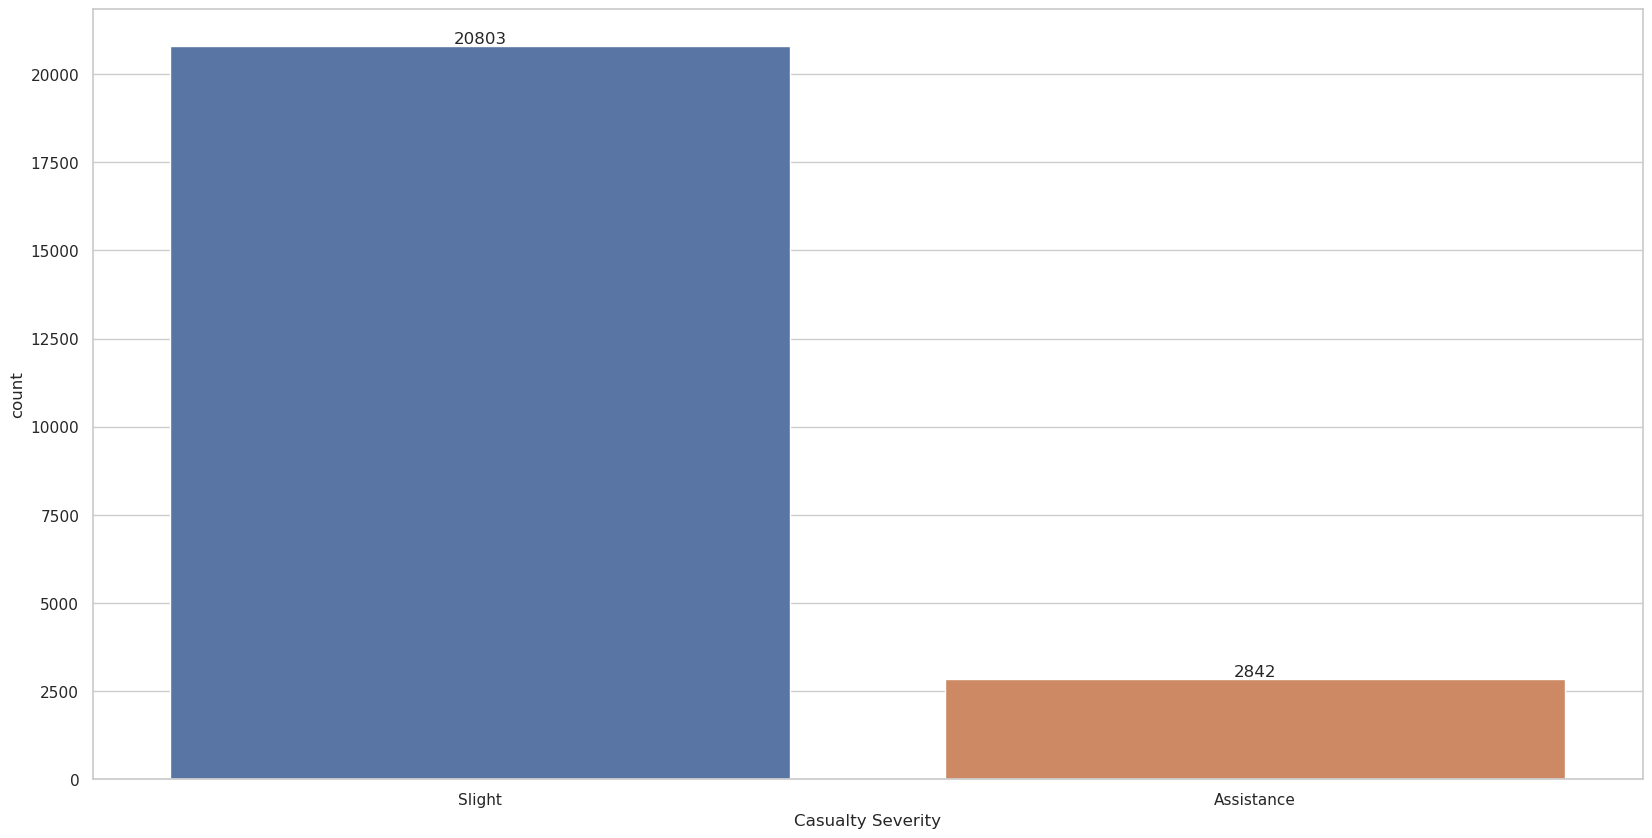

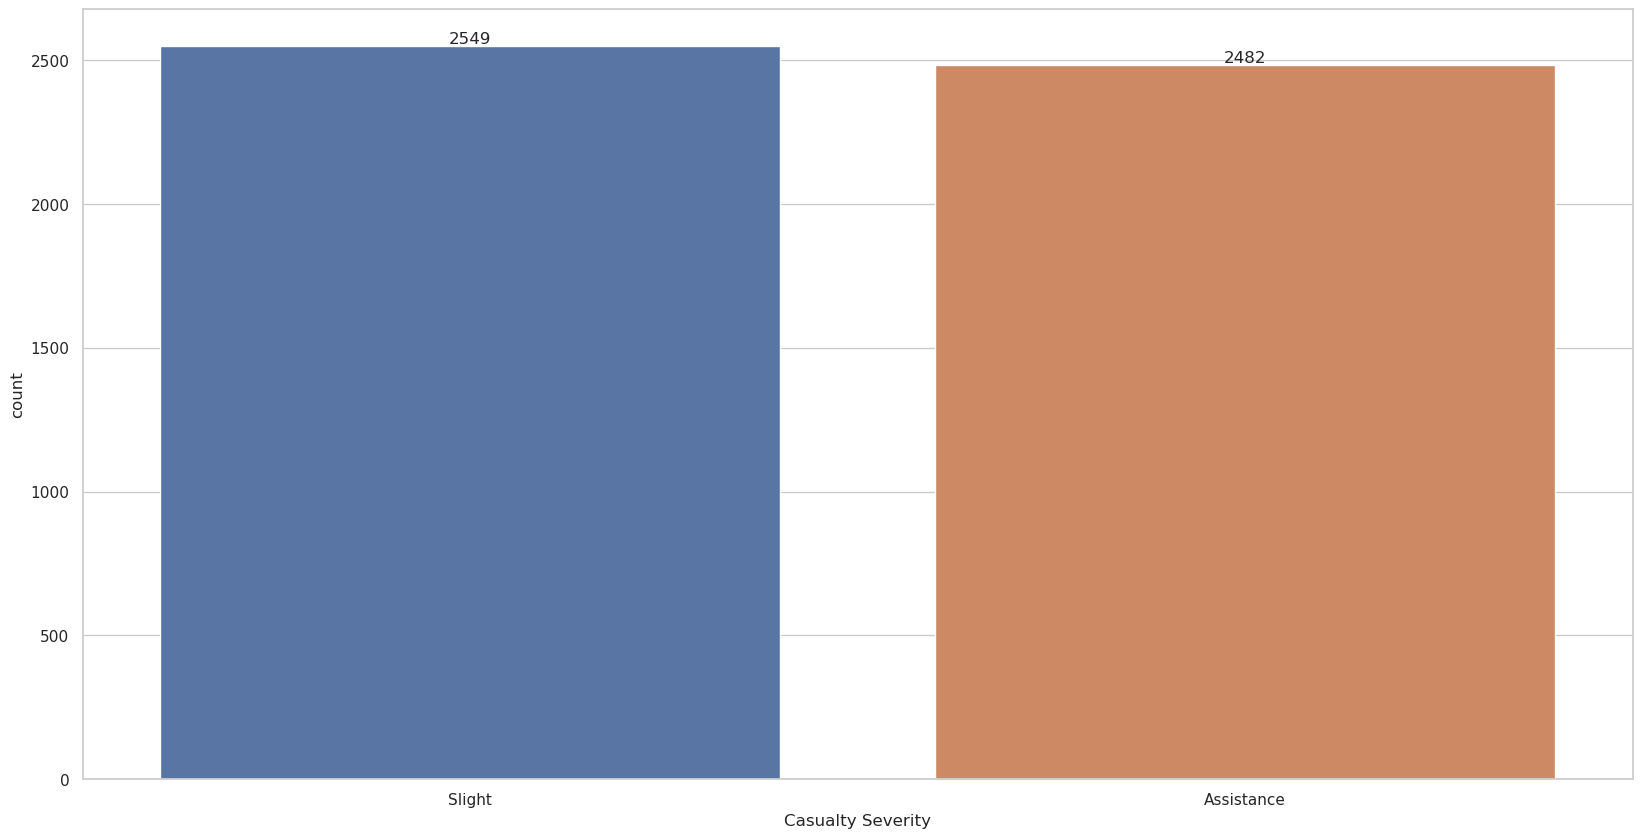

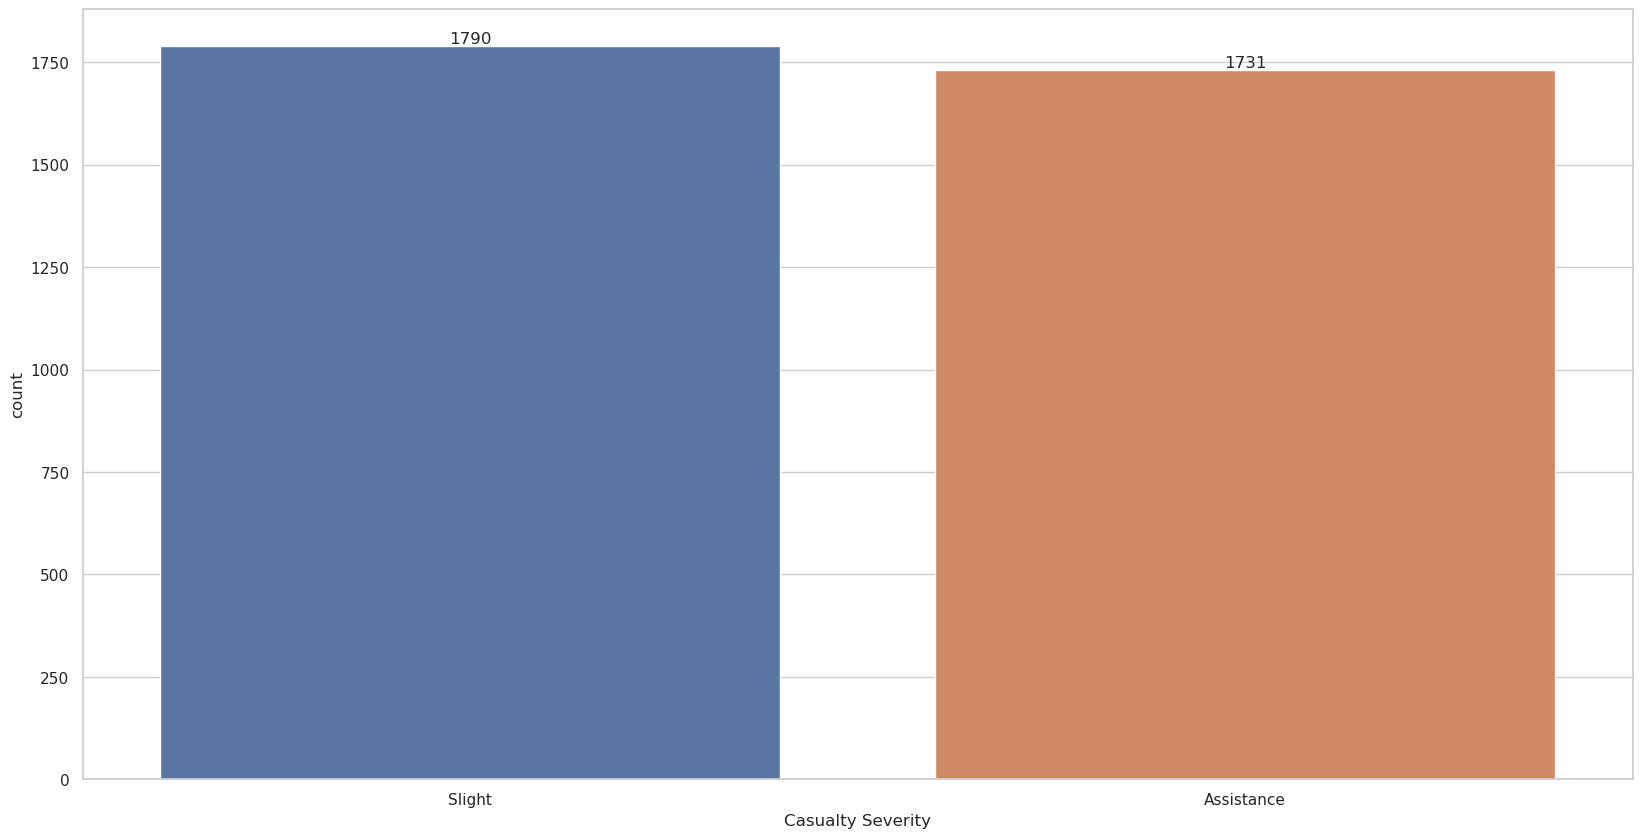

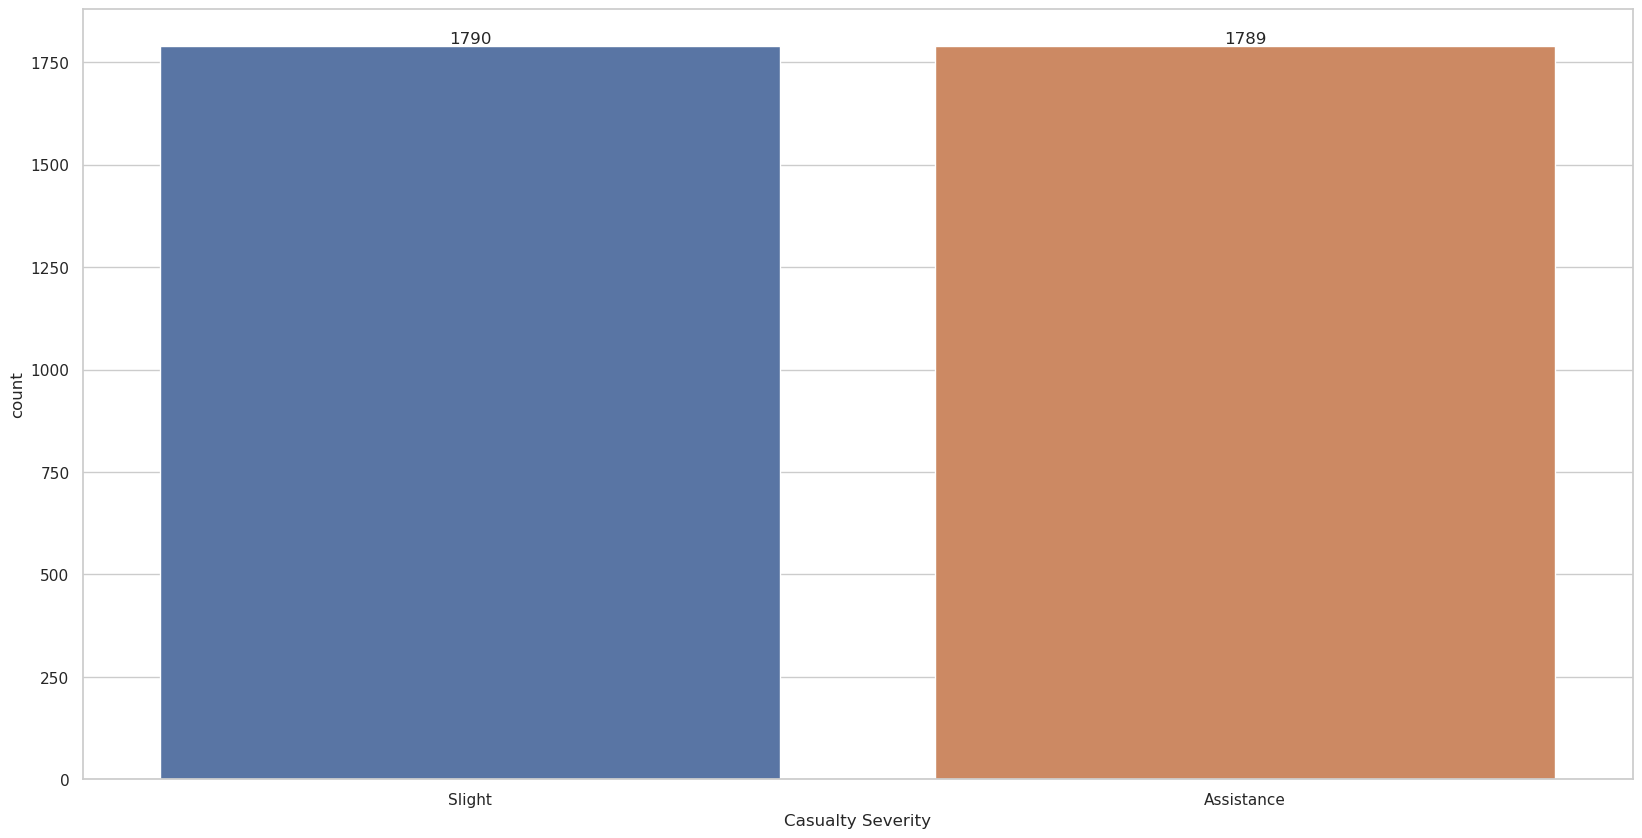

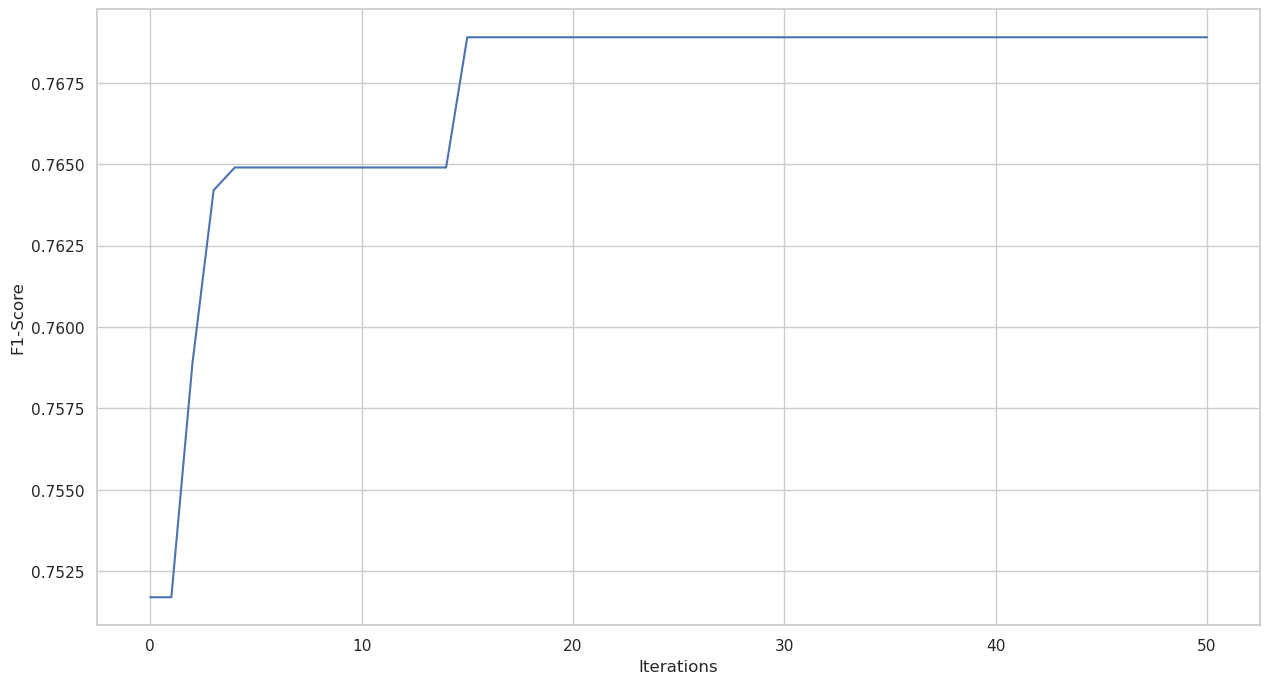

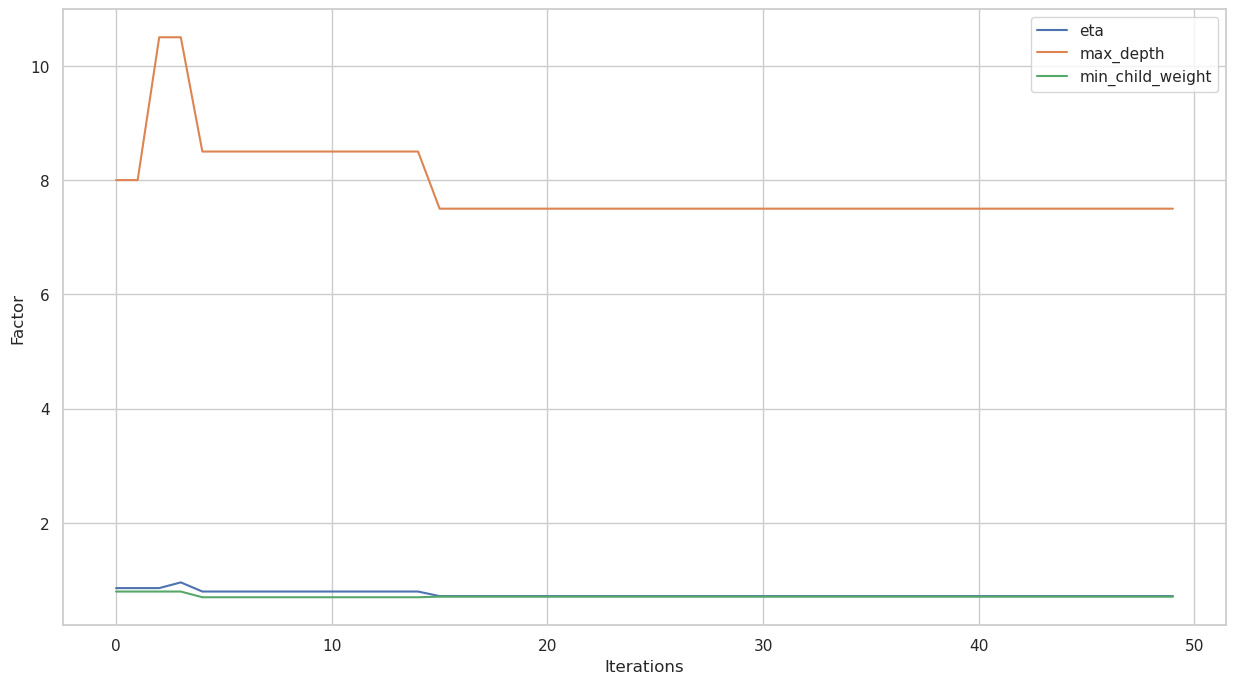

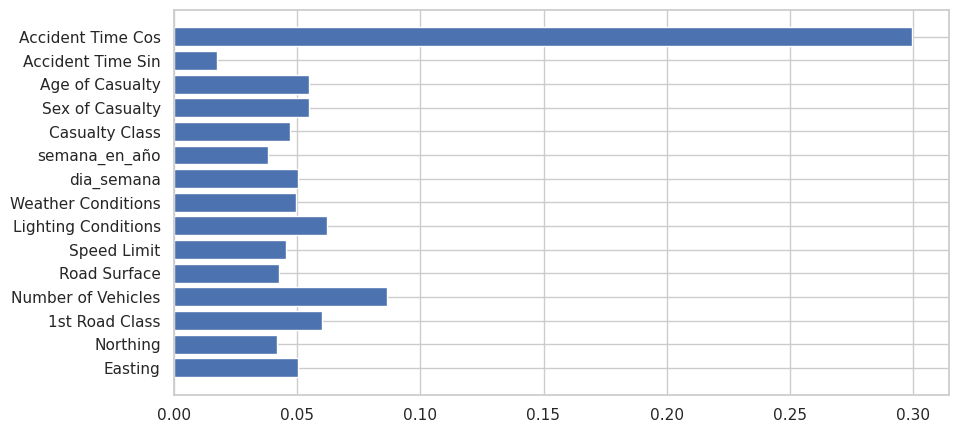

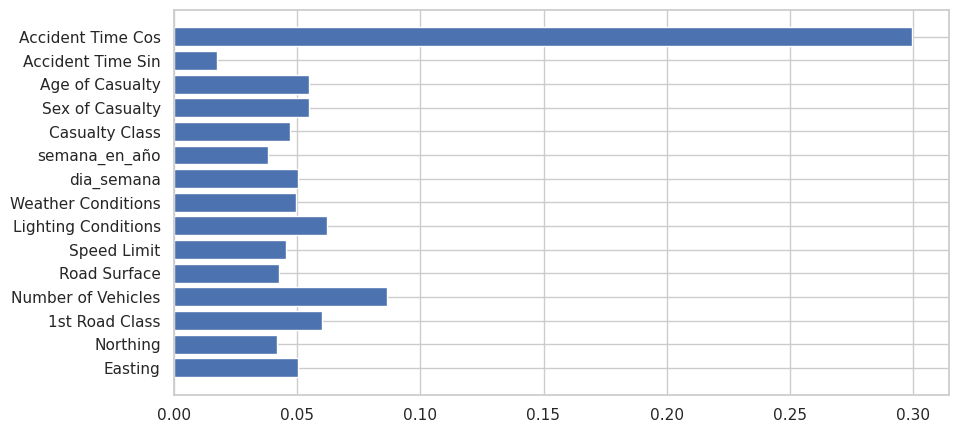

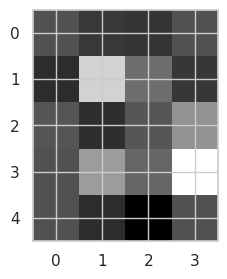

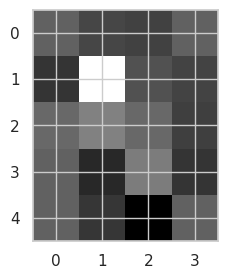

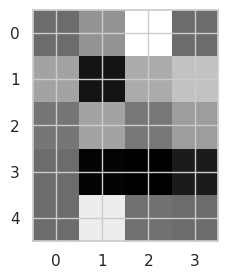

In [255]:
if city:
    plt.gray()
    for i in range(0,3):
        plt.figure(figsize=(3, 3))
        plt.imshow(train_bgi[:,:,i])
        # plt.savefig(f"{city_name}_image_example_{i}.svg",transparent=True)
        plt.show()

In [256]:
MODEL_TIMESTAMP

'2023-11-15-20:45:23'

In [257]:
# image = train_bgi[:,:,0]
# plt.figure(figsize=(6, 6))
# plt.imshow([image.flatten()])
# plt.savefig(f"test.svg",transparent=True, dpi=150)


In [258]:
# !conda install scikit-image

In [259]:
if city:
    # input_shape = (5, 5)

    array_train_images = np.asarray(train_images)
    array_test_images  = np.asarray(test_images)

    array_train_original_images = np.asarray(train_original_images)

In [260]:
# !conda install -c conda-forge tensorflow 

In [261]:
######### EN TERMINAL #########
# !pip install tensorflow-addons

## Visualización de datos

In [262]:
# !conda install seaborn

### Matriz de correlación

In [263]:
# correlation_matrix(X_test)

### PCA

In [264]:
# pca(X_train, X_test)

### TSNE

In [265]:
if city:
    n_samples = 150
    index_slight  = Y_train[Y_train == 'Slight'][:n_samples].index
    index_serious = Y_train[Y_train == 'Serious'][:n_samples].index
    index_fatal   = Y_train[Y_train == 'Fatal'][:n_samples].index

In [266]:
if city:
    # Get same number of class samples from SMOTEII
    X_slight_train_tsne  = X_train.loc[index_slight]
    X_serious_train_tsne = X_train.loc[index_serious]
    X_fatal_train_tsne   = X_train.loc[index_fatal]

    X_train_tsne = pd.concat([X_slight_train_tsne, X_serious_train_tsne, X_fatal_train_tsne])

    Y_slight_train_tsne  = Y_train[index_slight]
    Y_serious_train_tsne = Y_train[index_serious]
    Y_fatal_train_tsne   = Y_train[index_fatal]

    Y_train_tsne = pd.concat([Y_slight_train_tsne, Y_serious_train_tsne, Y_fatal_train_tsne])

In [267]:
if city:
    n_samples = len(Y_train_original[Y_train_original == 'Fatal'])

    index_slight  = Y_train_original[Y_train_original == 'Slight'][:n_samples].index
    index_serious = Y_train_original[Y_train_original == 'Serious'][:n_samples].index
    index_fatal   = Y_train_original[Y_train_original == 'Fatal'][:n_samples].index

In [268]:
if city:
    # Get same number of class samples from original
    X_slight_clean_tsne  = X_train_original.loc[index_slight]
    X_serious_clean_tsne = X_train_original.loc[index_serious]
    X_fatal_clean_tsne   = X_train_original.loc[index_fatal]

    X_clean_tsne = pd.concat([X_slight_clean_tsne, X_serious_clean_tsne, X_fatal_clean_tsne])

    Y_slight_clean_tsne  = Y_train_original[index_slight]
    Y_serious_clean_tsne = Y_train_original[index_serious]
    Y_fatal_clean_tsne   = Y_train_original[index_fatal]

    Y_clean_tsne = pd.concat([Y_slight_clean_tsne, Y_serious_clean_tsne, Y_fatal_clean_tsne])

In [269]:
if tsne and city:
    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras originales 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_test_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras originales 3 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_tsne_train_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_train_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 3 Componentes')

### Autoencoder

#### Entrenamiento

In [270]:
# X_train = array_train_images
# X_test = array_test_images
# X_train_original = array_train_original_images

# X_train = X_train.reshape(len(array_train_images), 25)
# X_train_original = X_train_original.reshape(len(array_train_original_images), 25)
# X_test  = X_test.reshape(len(X_test), 25)

# autoencoder = autoencoder().fit(X_train, X_train,
#                                 epochs = 100,
#                                 batch_size = 128,
#                                 shuffle = True,
#                                 validation_data = (X_test, X_test))

#### Visualización

In [271]:
# # create encoder model
# encoder = Model(inputs=input_img, outputs=encoder2)
# encoder.summary()
# # create decoder model
# encoded_input = Input(shape=(3,))
# #lo que hace aqui es quedarse con las capas que corresponden al decodificador
# decoder_layer1 = autoencoder.layers[-2]
# decoder_layer2 = autoencoder.layers[-1]
# decoder = Model(inputs=encoded_input, outputs=decoder_layer2(decoder_layer1(encoded_input)))
# decoder.summary()
# # si miramos la salida, son simetricos el uno respecto al otro
# # encoder va de input a 3 y decoder de 3 a input

# # get latent vector for visualization
# latent_vector = encoder.predict(X_test)
# # # get decoder output to visualize reconstructed image
# # reconstructed_imgs = decoder.predict(latent_vector)


# # visualize in 3D plot
# from pylab import rcParams
# from mpl_toolkits.mplot3d import Axes3D

# rcParams['figure.figsize'] = 10, 8

# fig = plt.figure(1)
# ax = Axes3D(fig)

# xs = latent_vector[:, 0]
# ys = latent_vector[:, 1]
# zs = latent_vector[:, 2]

# color=['red','green','blue']

# for x, y, z, label in zip(xs, ys, zs, Y_test):
#     c = color[int(label)]
#     ax.text(x, y, z, label, backgroundcolor=c)
    
# ax.set_xlim(xs.min(), xs.max())
# ax.set_ylim(ys.min(), ys.max())
# ax.set_zlim(zs.min(), zs.max())

# plt.show()

# # X_test_encoded = encoder.predict(X_test, batch_size=32)
# # plt.figure(figsize=(6, 6))
# # plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
# # plt.colorbar()
# # plt.show()

## One-Hot

In [272]:
if city:
    Y_train_onehot = casualty_to_one_hot(Y_train)
    Y_train_original_onehot = casualty_to_one_hot(Y_train_original)
    Y_test_onehot  = casualty_to_one_hot(Y_test)

## Models

In [273]:
if city:
    array_train_images = np.asarray(train_images)
    # array_val_images   = np.asarray(val_images)
    array_test_images  = np.asarray(test_images)

    input_train_shape = (len(array_train_images), max_dimension_x, max_dimension_y, 1)
    # input_val_shape = (len(array_val_images), 5, 5, 1)
    input_test_shape  = (len(array_test_images), max_dimension_x, max_dimension_y, 1)

    array_train_images = array_train_images.reshape(input_train_shape)
    # array_val_images   = array_val_images.reshape(input_val_shape)
    array_test_images  = array_test_images.reshape(input_test_shape)

    Y_test_labels = one_hot_to_casualty(Y_test)

    from sklearn.utils import class_weight

    pesos = class_weight.compute_class_weight('balanced',
                                              classes = np.unique(Y_train_original),
                                              y = Y_train_original)


    print('\nPesos calculados:', pesos, '\n\n')


    # Keras espera un diccionario donde la clave sea el número de clase 
    # y el valor sea el peso calculado. 
    pesos = dict(enumerate(pesos))  


Pesos calculados: [0.98351955 1.01704217] 




In [274]:
import pickle
from joblib import dump, load

if city:
    times = pd.DataFrame()

### NB

In [275]:
MODEL_NAME = MODELS_NAME[0]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

sns.reset_defaults()

#### Entrenamiento

In [276]:
from sklearn.naive_bayes import GaussianNB

if city and train_nn and other_models:
    start = time.time()

    gnb = GaussianNB()
    gnb = gnb.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])


    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! nb in 0.0 (s)


#### Escritura del modelo

In [277]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(gnb, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [278]:
if city and not train_nn and other_models:

    gnb = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [279]:
if city and other_models:
    print("[INFO] evaluating model...")
    if train_nn:
        Y_train_predicted = gnb.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')
    Y_predicted = gnb.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.588   0.532     0.558  1789.000
Slight            0.573   0.627     0.599  1790.000
accuracy          0.579   0.579     0.579     0.579
macro avg         0.580   0.579     0.579  3579.000
weighted avg      0.580   0.579     0.579  3579.000
              precision  recall  f1-score   support
Assistance        0.584   0.490     0.533   751.000
Slight            0.565   0.655     0.606   759.000
accuracy          0.573   0.573     0.573     0.573
macro avg         0.574   0.572     0.570  1510.000
weighted avg      0.574   0.573     0.570  1510.000


### SVC

In [280]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

MODEL_NAME = MODELS_NAME[1]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [281]:
if city and train_nn and other_models:
    start = time.time()

    clf = SVC(gamma='auto')
    clf.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! svc in 0.2 (s)


#### Escritura del modelo

In [282]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [283]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    clf = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [284]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:
        Y_train_predicted = clf.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = clf.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.709   0.683     0.696  1789.000
Slight            0.694   0.720     0.707  1790.000
accuracy          0.701   0.701     0.701     0.701
macro avg         0.702   0.701     0.701  3579.000
weighted avg      0.702   0.701     0.701  3579.000
              precision  recall  f1-score   support
Assistance        0.658   0.602     0.629   751.000
Slight            0.637   0.690     0.662   759.000
accuracy          0.646   0.646     0.646     0.646
macro avg         0.647   0.646     0.646  1510.000
weighted avg      0.647   0.646     0.646  1510.000


### KNN

In [285]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

MODEL_NAME = MODELS_NAME[2]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

#### Entrenamiento

In [286]:
if city and train_nn and other_models:
    knn = KNeighborsClassifier(leaf_size = 7, n_neighbors = 91)

    start = time.time()

    knn.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

# leaf_size = list(range(1,10, 2))
# n_neighbors = list(range(1,100, 10))
# p = [1, 2]

# if city and train_nn and other_models:

#     start = time.time()

#     # Create new KNN object
#     hyperparameters = dict(leaf_size = leaf_size,
#                            n_neighbors = n_neighbors)

#     # Use GridSearch
#     knn_2 = KNeighborsClassifier(leaf_size = 7, n_neighbors = 91)

#     # Fit the model
#     clf = GridSearchCV(knn_2,
#                        hyperparameters,
#                        cv = 4)

#     knn = clf.fit(X_train, Y_train)

#     end = time.time()

#     ellapsed_time = round(end - start, 2)


#     model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
#     times = times.append(model_time)

#     # Print The value of best Hyperparameters

#     best_leaf_size  = knn.best_estimator_.get_params()['leaf_size']
#     best_n_neighbors = knn.best_estimator_.get_params()['n_neighbors']

#     print('Best leaf_size:', best_leaf_size)
#     print('Best n_neighbors:', best_n_neighbors)

#     df = pd.DataFrame({'best_leaf_size':[best_leaf_size], 'n_neighbors':[best_n_neighbors]})

#     FILE_NAME = f"{MODEL_NAME}/madrid_{MODEL_TIMESTAMP}.csv"

#     df.to_csv(HYPERPARAMS_PATH + FILE_NAME, index = True)

#### Escritura del modelo

In [287]:
if city and train_nn and other_models:

    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(knn, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [288]:
# if city and not train_nn and other_models:

#     version = 'X'
#     MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
#     MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{model_version}.joblib"

#     knn = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [289]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:
        Y_train_predicted = knn.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')
    Y_predicted = knn.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision  recall  f1-score  support
Assistance        0.621   0.563     0.591  1789.00
Slight            0.601   0.656     0.627  1790.00
accuracy          0.610   0.610     0.610     0.61
macro avg         0.611   0.610     0.609  3579.00
weighted avg      0.611   0.610     0.609  3579.00
              precision  recall  f1-score   support
Assistance        0.595   0.518     0.554   751.000
Slight            0.577   0.651     0.612   759.000
accuracy          0.585   0.585     0.585     0.585
macro avg         0.586   0.584     0.583  1510.000
weighted avg      0.586   0.585     0.583  1510.000


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Logistic Regression

In [290]:
from sklearn.linear_model import LogisticRegression

MODEL_NAME = MODELS_NAME[3]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [291]:
# train_nn = True

In [292]:
if city and train_nn and other_models:
    start = time.time()

    logistic_regression = LogisticRegression()  
    logistic_regression = logistic_regression.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! logistic_regression in 0.01 (s)


#### Escritura del modelo

In [293]:
if city and train_nn and other_models:

    os.makedirs(MODEL_PATH, exist_ok = True)
    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [294]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    logistic_regression = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [295]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_train_predicted = logistic_regression.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = logistic_regression.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.581   0.618     0.599  1789.000
Slight            0.592   0.555     0.573  1790.000
accuracy          0.586   0.586     0.586     0.586
macro avg         0.587   0.586     0.586  3579.000
weighted avg      0.587   0.586     0.586  3579.000
              precision  recall  f1-score   support
Assistance        0.561   0.595     0.578   751.000
Slight            0.574   0.539     0.556   759.000
accuracy          0.567   0.567     0.567     0.567
macro avg         0.567   0.567     0.567  1510.000
weighted avg      0.567   0.567     0.567  1510.000


### Random Forest

In [296]:
from sklearn.linear_model import LogisticRegression

MODEL_NAME = MODELS_NAME[4]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [297]:
if city and train_nn and other_models:
    start = time.time()

    xgboost = XGBClassifier()
    xgboost = XGBClassifier(n_estimators=2, max_depth=2, eta=0.01, min_child_weight= 6.8)
# "eta": 0.01, "max_depth": 2.0, "min_child_weight": 6.8}
    xgboost.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! random_forest in 0.08 (s)


#### Escritura del modelo

In [298]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [299]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    logistic_regression = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [300]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_train_predicted = xgboost.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = xgboost.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.573   0.757     0.653  1789.000
Slight            0.643   0.437     0.521  1790.000
accuracy          0.597   0.597     0.597     0.597
macro avg         0.608   0.597     0.587  3579.000
weighted avg      0.608   0.597     0.587  3579.000
              precision  recall  f1-score   support
Assistance        0.558   0.740     0.637   751.000
Slight            0.621   0.420     0.501   759.000
accuracy          0.579   0.579     0.579     0.579
macro avg         0.589   0.580     0.569  1510.000
weighted avg      0.590   0.579     0.568  1510.000


### MLP

In [301]:
from sklearn.neural_network import MLPClassifier

MODEL_NAME = MODELS_NAME[5]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [302]:
if city and train_nn and other_models:
    start = time.time()

    clf = MLPClassifier()

    clf.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! mlp in 1.84 (s)


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Escritura del modelo

In [303]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [304]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    clf = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [305]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_predicted = clf.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_predicted,
                                                         data = 'train')
    Y_predicted = clf.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Assistance        0.771   0.760     0.766  1789.000
Slight            0.764   0.775     0.769  1790.000
accuracy          0.768   0.768     0.768     0.768
macro avg         0.768   0.768     0.768  3579.000
weighted avg      0.768   0.768     0.768  3579.000
              precision  recall  f1-score   support
Assistance        0.665   0.613     0.638   751.000
Slight            0.644   0.694     0.668   759.000
accuracy          0.654   0.654     0.654     0.654
macro avg         0.654   0.653     0.653  1510.000
weighted avg      0.654   0.654     0.653  1510.000


### Convolution 1D

In [306]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [307]:
MODEL_NAME = MODELS_NAME[6]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

#### Entrenamiento

In [308]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [309]:
if city and train_nn and cnn1d and not calculate_cnn_hyperparams:
    
    fm_one, fm_two, fm_three, fm_four = (64, 512, 128, 256)
    n_classes = Y_train.unique()

    dense  = 256

    learnRate = 0.001

    batchSize = 64

    start = time.time()

    convolution_1d =  get_1d_conv(fm_one = fm_one,
                           fm_two = fm_two,
                           fm_three = fm_three,
                           fm_four = fm_four,
                           dense = dense,
                           dropout = 0.2,
                           learnRate = learnRate)

    history = convolution_1d.fit(array_train_images, Y_train_onehot,
                                   # class_weight = pesos,
                                   batch_size = batchSize,
                                   epochs = 50,
                                   shuffle = True,
                                   validation_data = (array_test_images, Y_test_onehot),
                                   callbacks=[tensorboard_callback])

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': [ellapsed_time]})

    times = pd.concat([times, model_time])

    history

Epoch 1/50


ValueError: in user code:

    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/luis/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 5, 5, 1), found shape=(None, 5, 4, 1)


In [ ]:
# if city and train_nn and cnn1d and not calculate_cnn_hyperparams:
#     start = time.time()

#     fold_no = 1
#     # for train, test in kfold.split(inputs, targets):
#     history = convolution_1d.fit(array_train_images, Y_train_onehot,
#                                  # class_weight = pesos,
#                                  batch_size = 64,
#                                  epochs = 100,
#                                  shuffle = True,
#                                  validation_data = (array_test_images, Y_test_onehot))
#     end = time.time()

#     ellapsed_time = round(end - start, 2)

#     model_time = pd.DataFrame({'city': [city_name],
#                                'model': [MODEL_NAME],
#                                'time': [ellapsed_time]})

#     times = times.append(model_time)

#     history

In [ ]:
# if city and train_nn and not calculate_cnn_hyperparams:
    
#     fm_one, fm_two, fm_three, fm_four = (64, 512, 1024, 512)
#     n_classes = Y_train.unique()

#     dense  = 32

#     learnRate = 0.001

#     batchSize = 32

#     start = time.time()

#     convolution_1d = get_1d_conv(fm_one = fm_one,
#                            fm_two = fm_two,
#                            fm_three = fm_three,
#                            fm_four = fm_four,
#                            dense = dense,
#                            dropout = 0.2,
#                            learnRate = learnRate)

#     history = convolution_1d.fit(array_train_images, Y_train_onehot,
#                            # class_weight = pesos,
#                            batch_size = batchSize,
#                            epochs = 1,
#                            shuffle = True,
#                            validation_data = (array_test_images, Y_test_onehot))

#     end = time.time()

#     ellapsed_time = round(end - start, 2)

#     model_time = pd.DataFrame({'city': [city_name],
#                                'model': [MODEL_NAME],
#                                'time': [ellapsed_time]})
#     times = times.append(model_time)    

#     history

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
calculate_cnn_hyperparams=True
if city and train_nn and cnn1d and calculate_cnn_hyperparams:

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': 0})
    times = times.append(model_time)
    # wrap our model into a scikit-learn compatible classifier
    print("[INFO] initializing model...")
    model = KerasClassifier(build_fn=get_1d_conv, verbose=10)

    # define a grid of the hyperparameter search space

    # fm_one = fm_two = fm_three = fm_four = fm_five = fm_six = [32, 64, 128, 256, 512]
    fm_one = fm_two = fm_three = fm_four = [32, 64, 128, 256, 512, 1024]

    dense  = [32, 64, 128, 256]

    learnRate = [0.1, 1e-2, 1e-3, 1e-4]

    batchSize = [32, 64, 128]

    epochs = [60]

    # create a dictionary from the hyperparameter grid
    grid = dict(
        fm_one = fm_one,
        fm_two = fm_two,
        fm_three = fm_three,
        fm_four = fm_four,
        dense = dense,
        learnRate=learnRate,
        batch_size=batchSize,
        epochs=epochs
    )

    # initialize a random search with a 3-fold cross-validation and then
    # start the hyperparameter search process
    print("[INFO] performing random search...")
    searcher = RandomizedSearchCV(estimator = model,
                                  n_iter = 50,
                                  cv = 3,
                                  param_distributions = grid,
                                  scoring = 'f1_micro')

    searchResults = searcher.fit(array_train_images, Y_train)

    # summarize grid search information
    bestScore = searchResults.best_score_
    bestParams = searchResults.best_params_

    print("[INFO] best score is {:.2f} using {}".format(bestScore,	bestParams))

    print("[INFO] evaluating the best model...")
    convolution1d = bestModel = searchResults.best_estimator_
    # accuracy = bestModel.score(array_test_images, Y_test)
    # print("accuracy: {:.2f}%".format(accuracy * 100))

    text_file = open(f"./CNN1D-{MODEL_TIMESTAMP}.txt", "w")
    n = text_file.write(str(searchResults.cv_results_))
    text_file.close()

#### Escritura del modelo

In [ ]:
if city and train_nn and cnn1d:
    os.makedirs(MODEL_PATH, exist_ok = True)

    convolution_1d.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [ ]:
if city and not train_nn and not laptop and cnn1d:
    # MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{loaded_timestamp}.h5"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_2022-07-19-08:49:34.h5"
    # MODEL_FILE_NAME = 'madrid_convolution_1d_2022-05-19-06:33:55.h5'

    convolution_1d = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [ ]:
if city and cnn1d:

    print("[INFO] evaluating network...")

    Y_predicted = convolution_1d.predict(x = array_test_images).argmax(axis = 1)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

        plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
                              f1_score_name = F1_SCORE_NAME,
                              history = history)

        Y_train_predicted = convolution_1d.predict(x = array_train_images).argmax(axis = 1)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

### Convolution 2D

In [310]:
MODEL_NAME = MODELS_NAME[7]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

#### Entrenamiento

In [311]:

if city and cnn2d and not False:
    
    fm_one, fm_two, fm_three, fm_four = (256, 512, 256, 32)
    n_classes = Y_train.unique()

    dense  = 512

    learning_rate = 1e-05

    batchSize = 32

    start = time.time()

    tasp_cnn = get_tasp_cnn_o(max_dimension_x,
                              max_dimension_y,
                              fm_one = fm_one,
                              fm_two = fm_two,
                              fm_three = fm_three,
                              fm_four = fm_four,
                              dense = dense,
                              dropout = 0.2,
                              learning_rate = learning_rate)

    history = tasp_cnn.fit(array_train_images, Y_train_onehot,
                           # class_weight = pesos,
                           batch_size = batchSize,
                           epochs = 50,
                           shuffle = True,
                           validation_data = (array_test_images, Y_test_onehot))

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    history

Epoch 1/50
112/112 [==============================] - 2s 10ms/step - loss: 0.7318 - f1_score: 0.6728 - val_loss: 0.7019 - val_f1_score: 0.6667
Epoch 2/50
112/112 [==============================] - 1s 9ms/step - loss: 0.5938 - f1_score: 0.7112 - val_loss: 0.7041 - val_f1_score: 0.6667
Epoch 3/50
112/112 [==============================] - 1s 8ms/step - loss: 0.5282 - f1_score: 0.7329 - val_loss: 0.6915 - val_f1_score: 0.6665
Epoch 4/50
112/112 [==============================] - 1s 10ms/step - loss: 0.4829 - f1_score: 0.7543 - val_loss: 0.6539 - val_f1_score: 0.6723
Epoch 5/50
112/112 [==============================] - 1s 10ms/step - loss: 0.4404 - f1_score: 0.7739 - val_loss: 0.6113 - val_f1_score: 0.6917
Epoch 6/50
112/112 [==============================] - 1s 9ms/step - loss: 0.4120 - f1_score: 0.7875 - val_loss: 0.5603 - val_f1_score: 0.7223
Epoch 7/50
112/112 [==============================] - 1s 11ms/step - loss: 0.3812 - f1_score: 0.8052 - val_loss: 0.5321 - val_f1_score: 0.7379
Ep

In [312]:
with open(f'CNN2D_{MODEL_TIMESTAMP}.txt', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [313]:
# from kerastuner import RandomSearch
# #creating randomsearch object
# tuner = RandomSearch(build_model,
#                      objective='val_accuracy',
#                      max_trials = 5)
# # search best parameter
# tuner.search(train_df,train_labl,epochs=3,validation_data=(train_df,train_labl))

In [314]:
X_train_singled = array_train_images.reshape((len(array_train_images), -1))
X_train_singled

array([[ 0.        , -0.39008945, -0.45737298, ..., -0.60723146,
        -1.34748979,  0.        ],
       [ 0.        , -0.39008945, -0.45737298, ..., -0.60723146,
        -1.34748979,  0.        ],
       [ 0.        ,  0.30324975,  1.12146062, ...,  0.98122469,
         0.03736472,  0.        ],
       ...,
       [ 0.        , -0.39008945, -0.45737298, ..., -0.60723146,
         0.25442017,  0.        ],
       [ 0.        , -0.39008945, -0.45737298, ..., -0.60723146,
         0.13393484,  0.        ],
       [ 0.        , -0.18685339,  1.77469844, ..., -0.14161295,
        -1.34748979,  0.        ]])

https://www.google.com/search?channel=fs&client=ubuntu&q=gridsearch+sklearn+custom+validation


https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn


https://scikit-learn.org/stable/modules/cross_validation.html#predefined-fold-splits-validation-sets


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html#sklearn.model_selection.PredefinedSplit

In [315]:
from sklearn.preprocessing import OneHotEncoder

Y_train_array = np.asarray(Y_train)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = Y_train_array.reshape(len(Y_train_array), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
train_onehot_encoded = onehot_encoded.astype(int)

Y_test_array = np.asarray(Y_test)
integer_encoded = Y_test_array.reshape(len(Y_test_array), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
test_onehot_encoded = onehot_encoded.astype(int)

In [316]:
from sklearn.model_selection import PredefinedSplit

# -1 para train
# 0 para test
train_indexes = [-1] * array_train_images.shape[0]
test_indexes  = [0] * array_test_images.shape[0]

predefined_splitted_y_indexes = np.array(train_indexes + test_indexes)
predefined_splitted_x = np.concatenate((array_train_images, array_test_images), axis=0)
predefined_splitted_onehot = np.concatenate((train_onehot_encoded, test_onehot_encoded), axis=0)

ps = PredefinedSplit(predefined_splitted_y_indexes)

for i, (train_index, test_index) in enumerate(ps.split()):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[   0    1    2 ... 3576 3577 3578]
  Test:  index=[3579 3580 3581 ... 5086 5087 5088]


In [317]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

calculate_cnn_hyperparams=False
if city and cnn2d and calculate_cnn_hyperparams:

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': 0})

    times = pd.concat([times, model_time])
    # wrap our model into a scikit-learn compatible classifier
    print("[INFO] initializing model...")

    model = KerasClassifier(model=get_tasp_cnn_o, fm_one=1, fm_two=2, fm_three=3, fm_four=4,learning_rate=1, dense=1,epochs=10, batch_size=512, verbose=0)

    # define a grid of the hyperparameter search space

    # fm_one = fm_two = fm_three = fm_four = fm_five = fm_six = [32, 64, 128, 256, 512]
    fm_one = fm_two = fm_three = fm_four = [32, 64, 128, 256, 512, 1024]

    dense  = [32, 64, 128, 256, 512]

    learning_rate = [0.1, 1e-2, 1e-3, 1e-4, 1e-5]

    batchSize = [32, 64, 128, 256]

    epochs = [50]

    # create a dictionary from the hyperparameter grid
    grid = dict(
        fm_one = fm_one,
        fm_two = fm_two,
        fm_three = fm_three,
        fm_four = fm_four,
        dense = dense,
        learning_rate=learning_rate,
        batch_size=batchSize,
        epochs=epochs
    )

    number_of_configs = 150

    # initialize a random search with a 3-fold cross-validation and then
    # start the hyperparameter search process
    print("[INFO] performing random search...")
    searcher = RandomizedSearchCV(estimator = model,
                                  n_iter = number_of_configs,
                                  cv = ps,
                                  param_distributions = grid,
                                  scoring = 'f1_micro')

    searchResults = searcher.fit(predefined_splitted_x, predefined_splitted_onehot)

    # summarize grid search information
    bestScore = searchResults.best_score_
    bestParams = searchResults.best_params_

    print("[INFO] best score is {:.2f} using {}".format(bestScore,	bestParams))

    print("[INFO] evaluating the best model...")
    taspcnn = bestModel = searchResults.best_estimator_
    # accuracy = bestModel.score(array_test_images, Y_test)
    # print("accuracy: {:.2f}%".format(accuracy * 100))

    text_file = open(f"./CNN2D-{MODEL_TIMESTAMP}.txt", "w")
    n = text_file.write(str(searchResults.cv_results_))
    text_file.close()
    
    searchResults.best_estimator_.epochs

#### Escritura del modelo

In [318]:
if city and cnn2d:
    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

    os.makedirs(MODEL_PATH, exist_ok = True)

    tasp_cnn.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [319]:
if city and not train_nn and cnn2d:
    # MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_2022-07-19-08:49:34.h5"
    # MODEL_FILE_NAME = 'madrid_convolution_2d_2022-05-18-19:50:16.h5'

    tasp_cnn = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

In [320]:
# ## Exportar los kernels

# n_samples = 3
# layers = [0, 2, 4, 6]

# for layer_number in layers:
#     filters, biases = tasp_cnn.layers[layer_number].get_weights()
    
#     layer_name = layer_number//2 + 1

#     for i in range(n_samples):
#         # X,Y, channel, filter_number
#         current_filter = filters[:,:,0, i]

#         plt.figure(figsize=(3, 3))
#         plt.grid(b = None)
#         plt.imshow(current_filter, cmap='gray')

#         # plt.savefig(f"filters/{city_name}_filter_layer_{layer_name}_{i}.svg", transparent=True)
#         plt.show()

In [321]:
# # import tf.keras.mo.Model
# tasp_cnn_feature_maps = tf.keras.models.Model(inputs = tasp_cnn.inputs, outputs=tasp_cnn.layers[0].output)

# tasp_cnn_feature_maps.predict(array_train_images[:3]).shape

In [322]:
# feature_maps = tasp_cnn.predict(array_train_images)
# # plot all 64 maps in an 8x8 squares
# square = 5
# ix = 1
# for _ in range(square):
#     for _ in range(square):
#         # specify subplot and turn of axis

#         # plot filter channel in grayscale
#         plt.imshow(tasp_cnn_feature_maps[ix-1,:,:,:], cmap='gray')
#         ix += 1
# # show the figure
# plt.show()

#### Resultados

[INFO] evaluating network...
48/48 [==============================] - 0s 750us/step


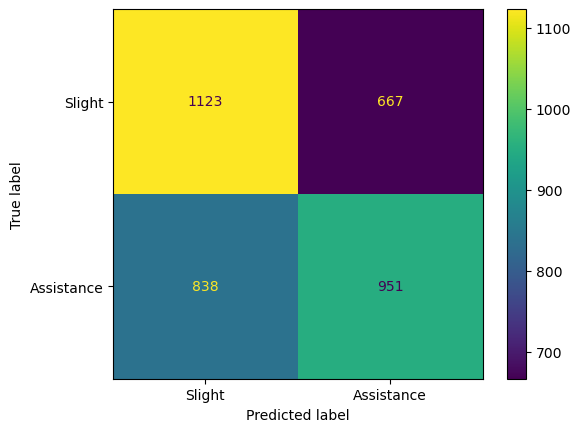

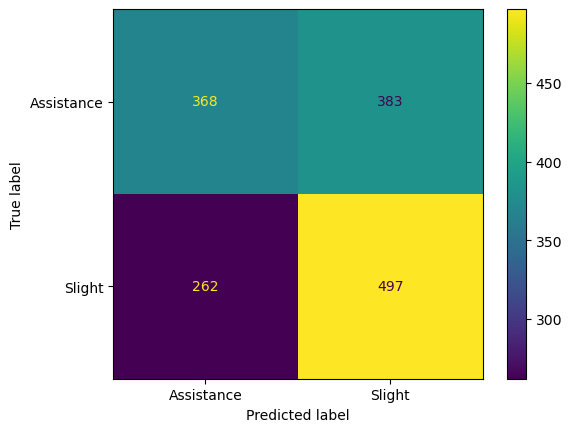

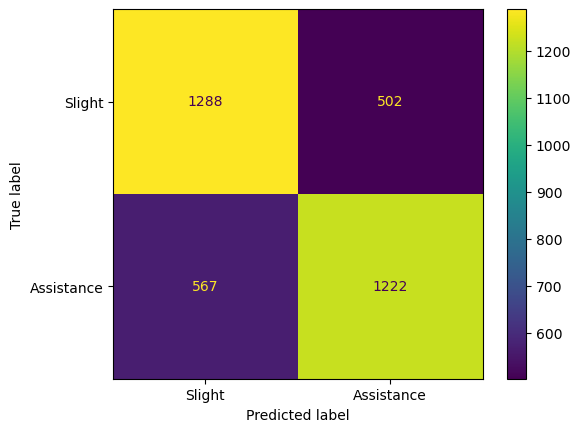

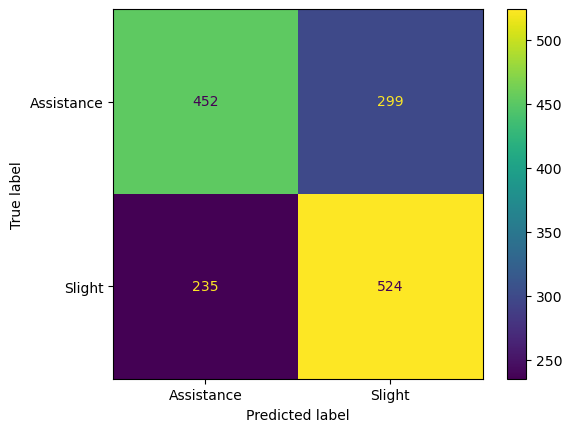

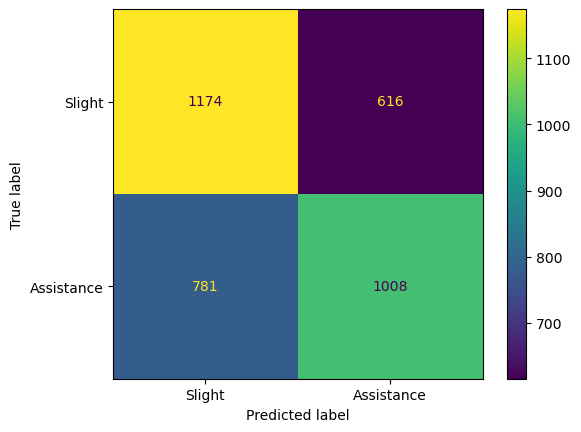

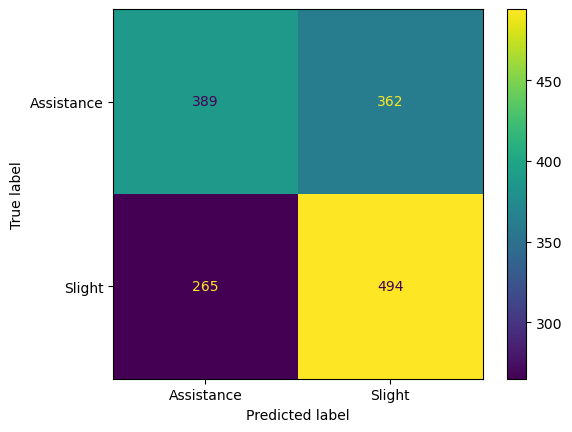

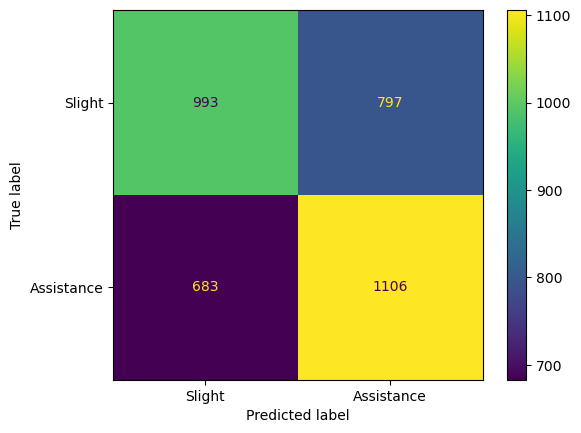

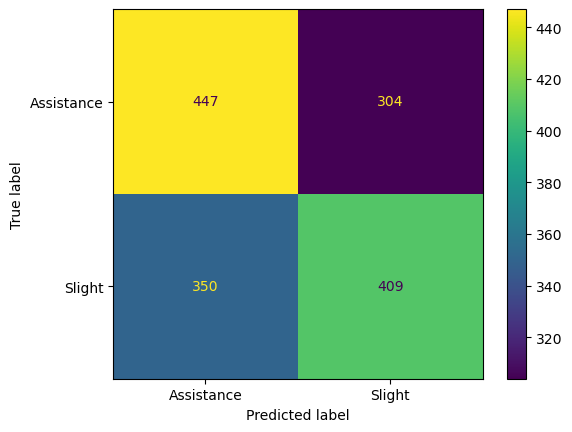

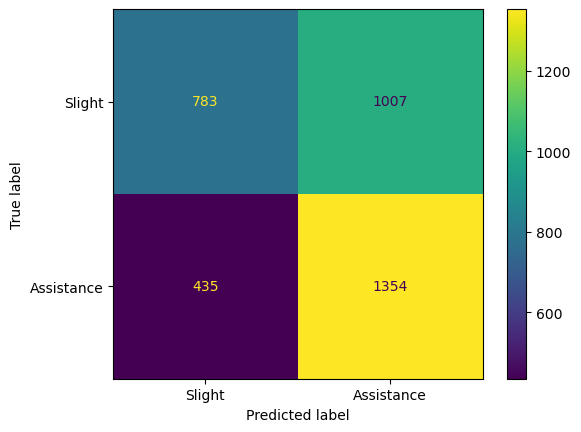

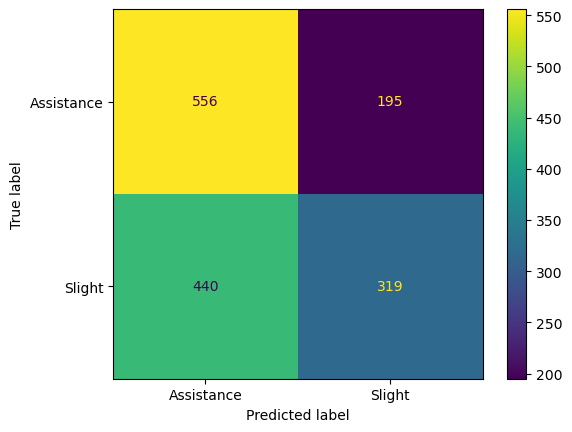

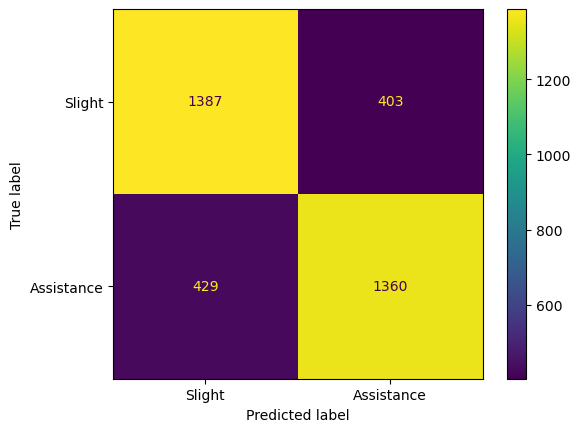

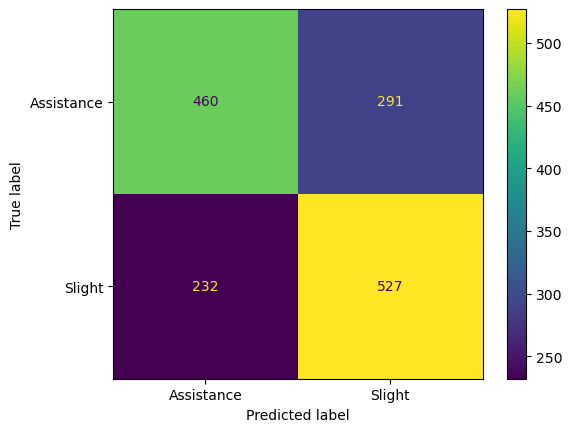

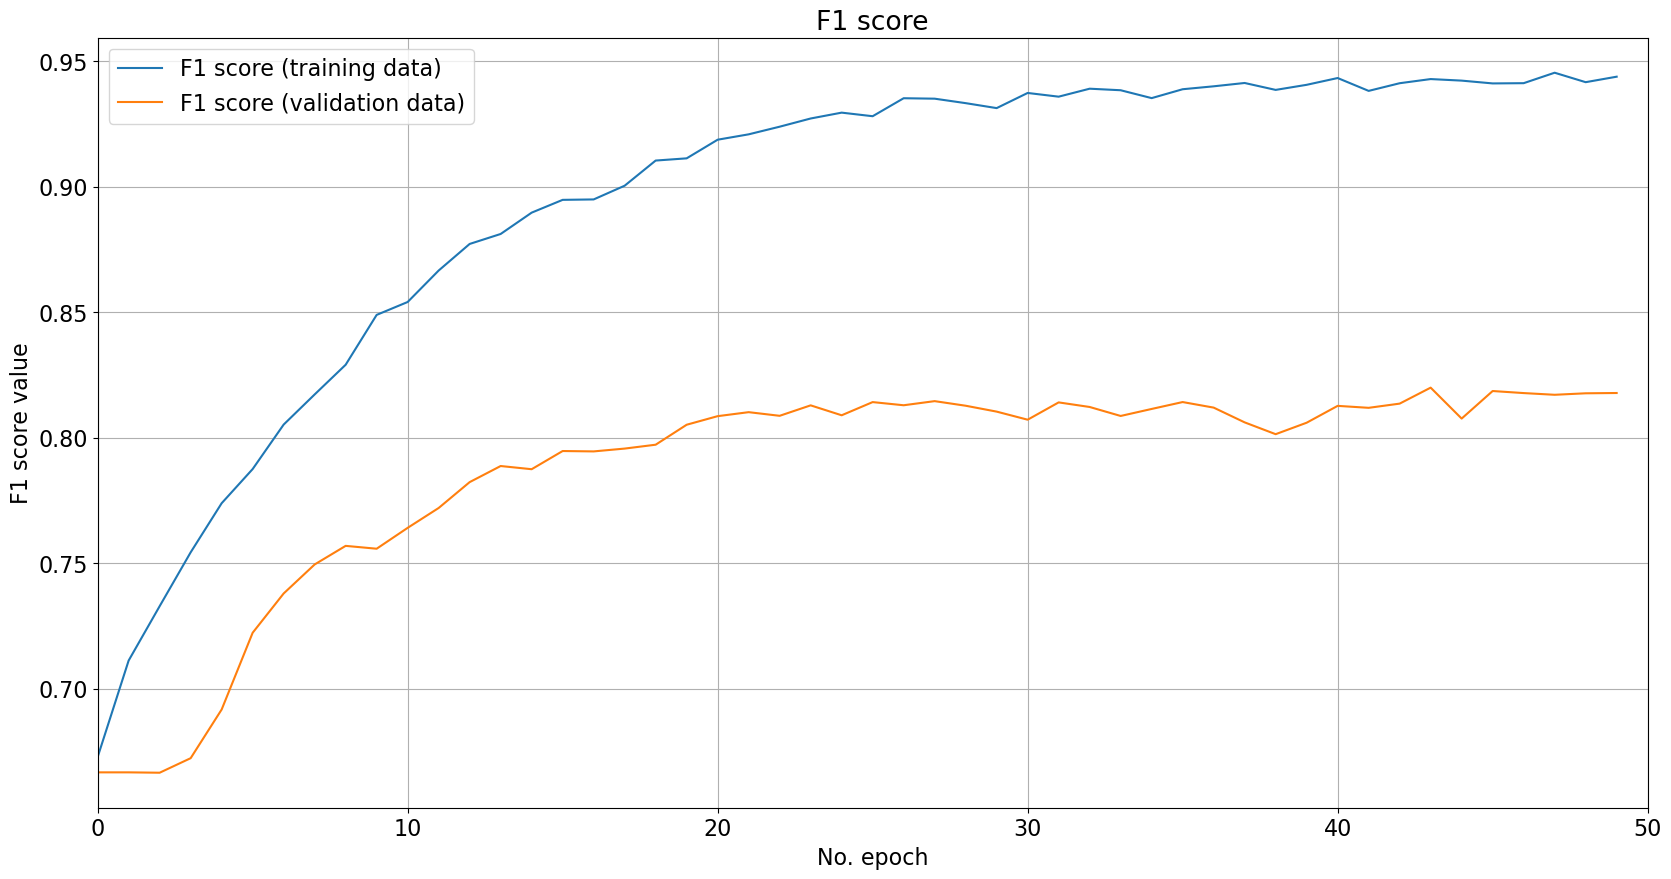

112/112 [==============================] - 0s 898us/step
              precision  recall  f1-score   support
Assistance        0.963   0.959     0.961  1789.000
Slight            0.959   0.964     0.961  1790.000
accuracy          0.961   0.961     0.961     0.961
macro avg         0.961   0.961     0.961  3579.000
weighted avg      0.961   0.961     0.961  3579.000
              precision  recall  f1-score   support
Assistance        0.805   0.792     0.799   751.000
Slight            0.798   0.810     0.804   759.000
accuracy          0.801   0.801     0.801     0.801
macro avg         0.801   0.801     0.801  1510.000
weighted avg      0.801   0.801     0.801  1510.000


In [323]:
if city and cnn2d:

    print("[INFO] evaluating network...")

    Y_predicted = tasp_cnn.predict(x = array_test_images).argmax(axis = 1)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_paper.svg"

        plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
                              f1_score_name = F1_SCORE_NAME,
                              history = history)

        Y_train_predicted = tasp_cnn.predict(x = array_train_images).argmax(axis = 1)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')


## AutoML

In [324]:
city_name

'Cornwall'

In [325]:
MODEL_NAME = MODELS_NAME[3]

# Data Summary

## Models times plot

### Sort

In [326]:
times = times.sort_values('time')

### Save csv

In [327]:
SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.csv"
times.to_csv(SAVE_PATH, index= True)

### Save fig

In [328]:
# LOAD_PATH = f"{REPORTS_TIMES_PATH}2022-05-23-15:28:04.csv"
# times = pd.read_csv(LOAD_PATH)

# ax = sns.barplot(x = 'time',
#                  y = 'model',
#                  palette='deep',
#                  data = times).set(title = f"Models Fitting Time (s)")
# plt.xlabel("Time (s)")

# SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.png"
# plt.savefig(SAVE_PATH)

## Models metrics file

Found: nb for train
Found: knn for train
Found: logistic_regression for train
Found: random_forest for train
Found: svc for train
Found: mlp for train
Found: convolution_2d for train
Found: nb for test
Found: knn for test
Found: logistic_regression for test
Found: random_forest for test
Found: svc for test
Found: mlp for test
Found: convolution_2d for test
Found: Reports/summary/train/2023-11-15-20:45:23.csv
Found: Reports/summary/test/2023-11-15-20:45:23.csv


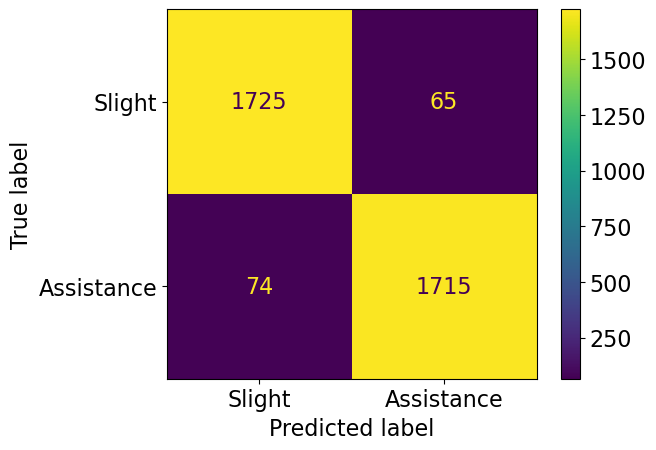

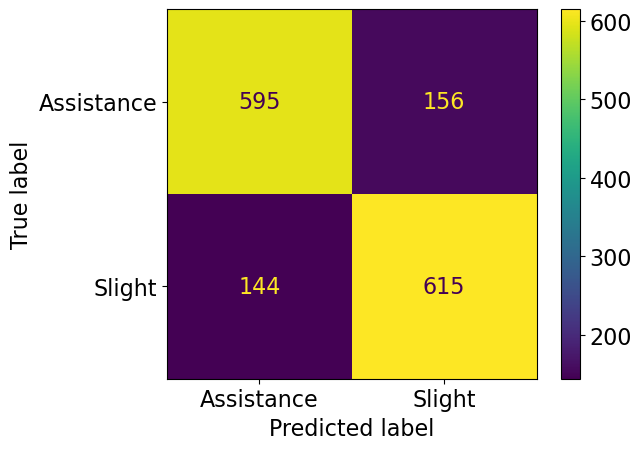

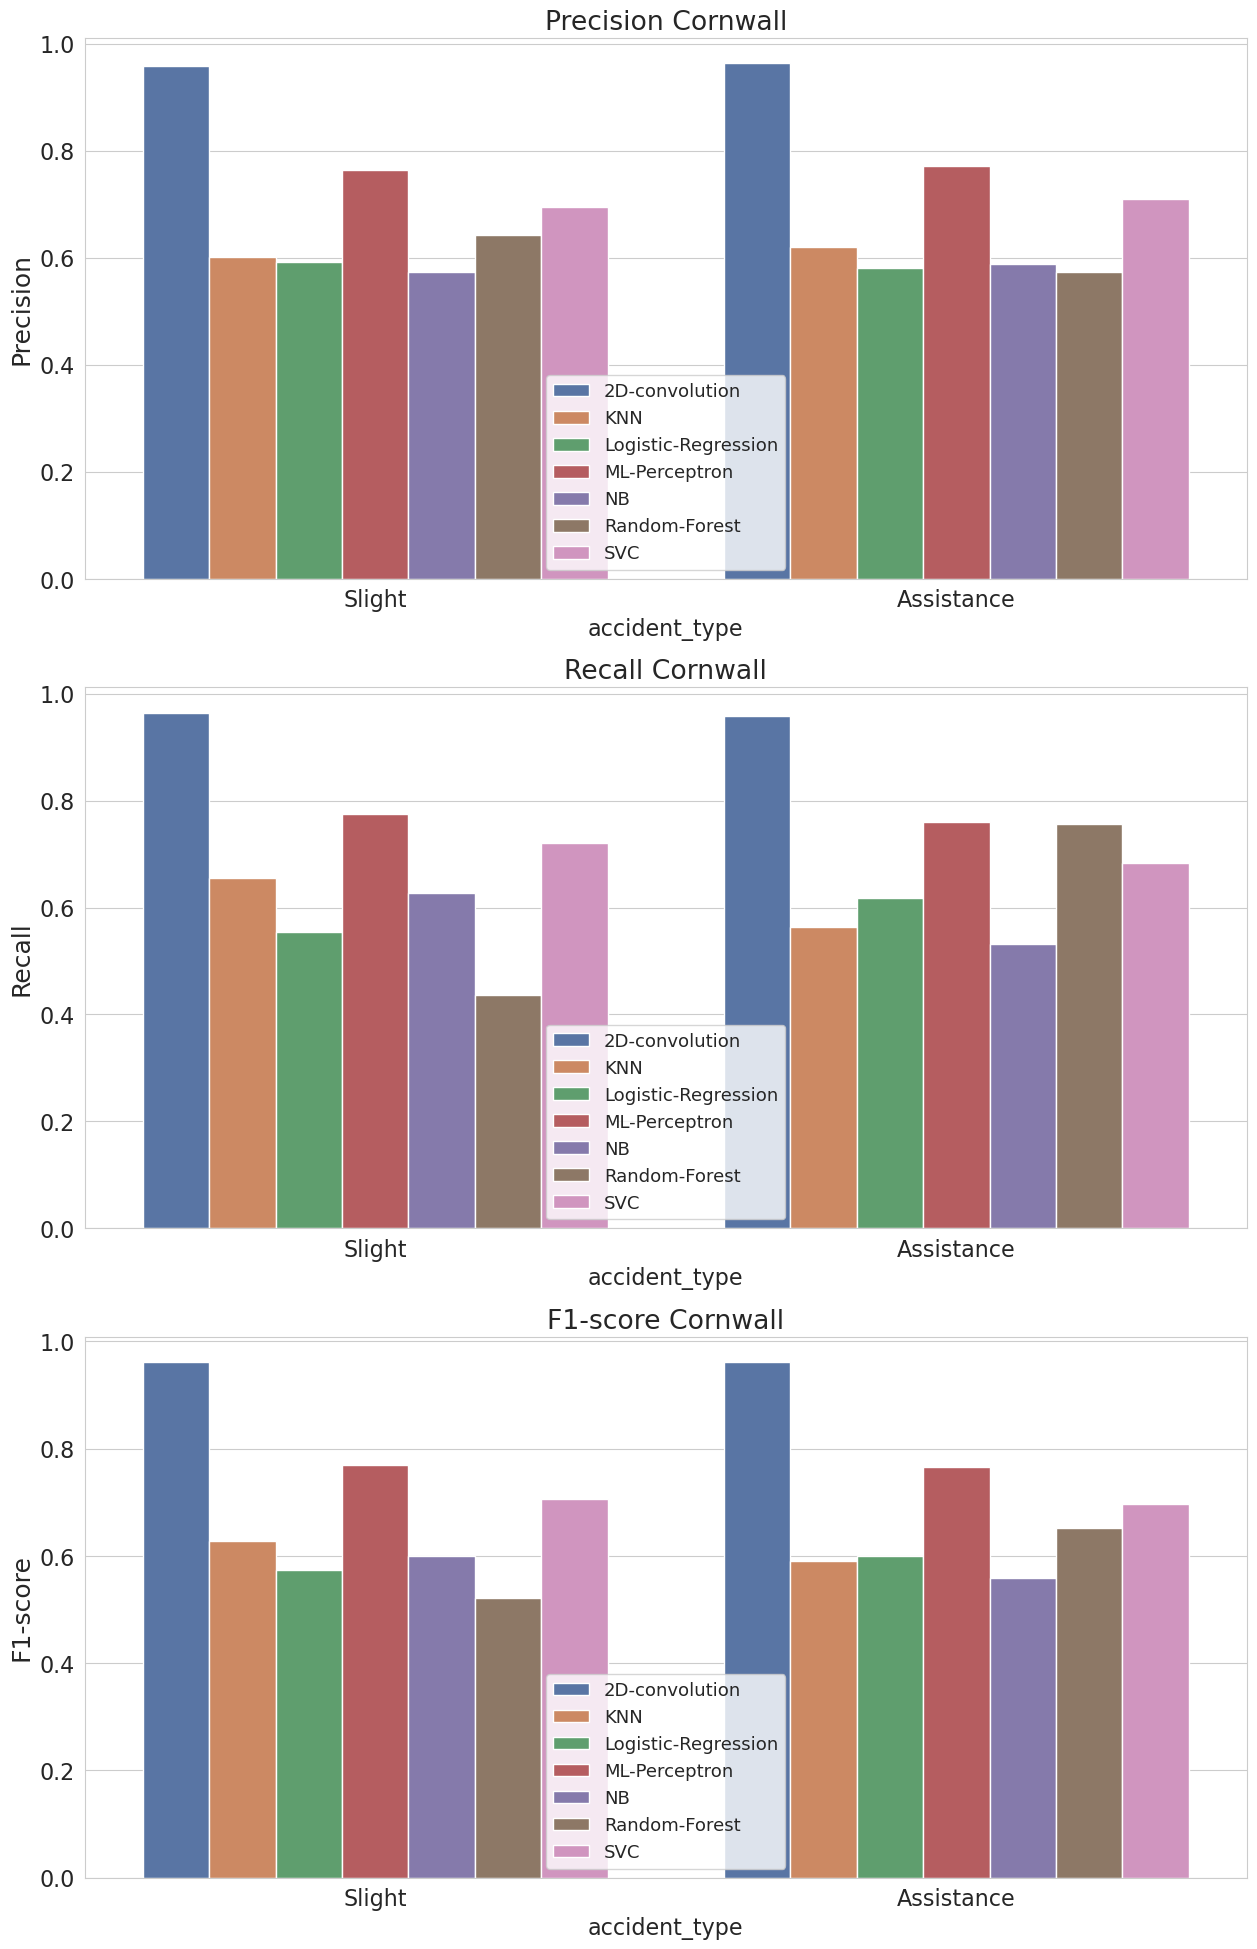

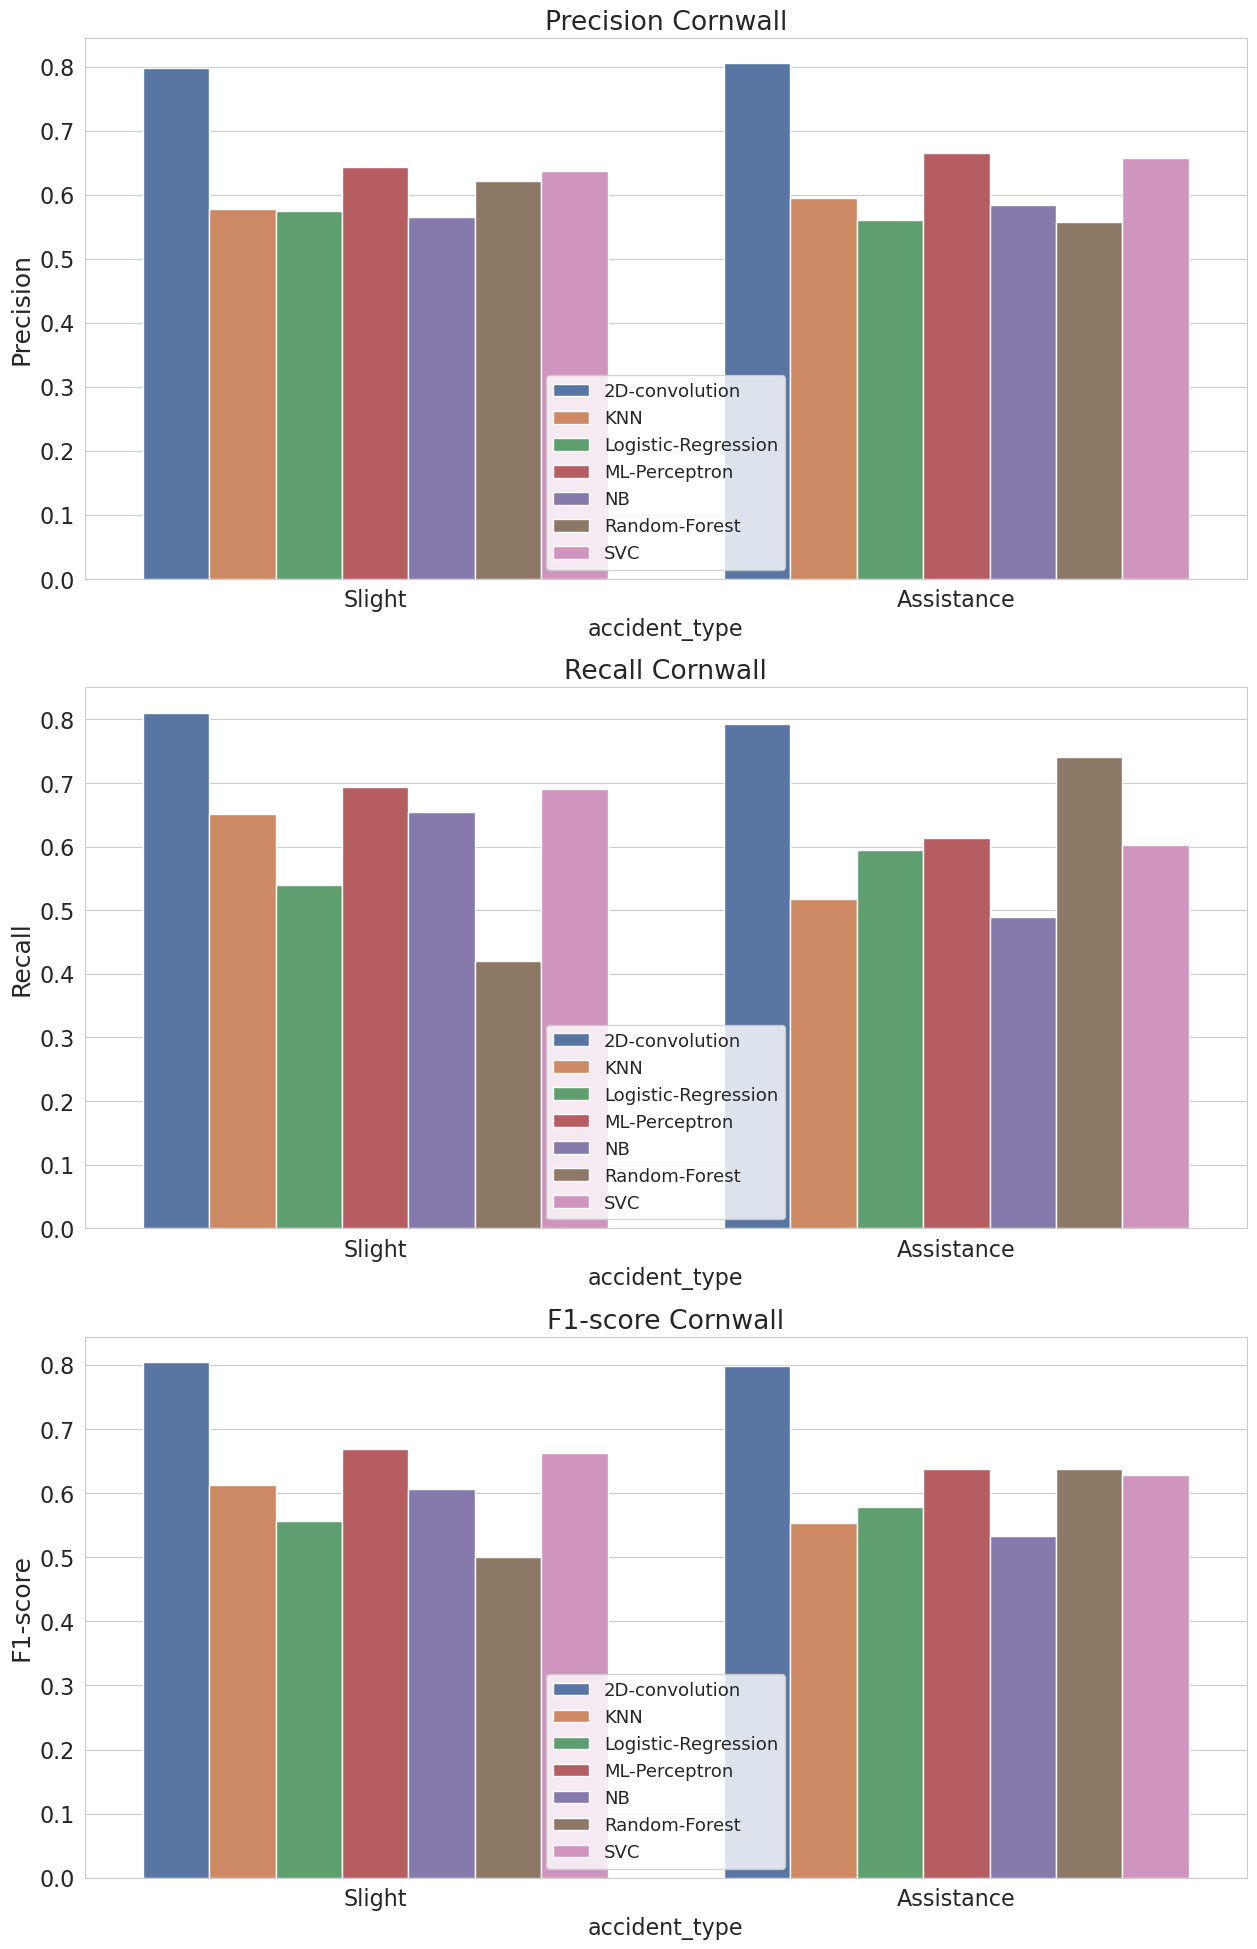

In [329]:
from src.mixins.plot import make_reports_summary
from src.mixins.plot import make_f1_score_barplot

city_name = 'Cornwall'
victoria = True

reports_summary, splits, cities = make_reports_summary(times, city_name, MODEL_TIMESTAMP, REPORTS_PATH, REPORTS_SUMMARY_PATH, leeds, madrid, UK)
make_f1_score_barplot(reports_summary, splits, city_name, cities, MODEL_TIMESTAMP, REPORTS_SUMMARY_PATH, leeds, madrid, UK)

## Models scores plot

In [330]:
REPORT_PATH

NameError: name 'REPORT_PATH' is not defined

In [ ]:
import seaborn as sns

MEASURE_TYPES  = ['precision', 'recall', 'f1-score']
# ACCIDENT_TYPES = ['Slight', 'Serious', 'Fatal']

ACCIDENT_TYPES = ['Slight', 'Assistance']


if leeds:
    leeds_reports_summary  = reports_summary[reports_summary['city'] == 'leeds']
if False: #madrid:
    madrid_reports_summary = reports_summary[reports_summary['city'] == 'madrid']
if UK:
    UK_reports_summary = reports_summary[reports_summary['city'] == city_name]

# print(leeds_reports_summary.loc[ACCIDENT_TYPES])

for split in splits:
    
    REPORT_PATH = f"{REPORTS_SUMMARY_PATH}{split}/{MODEL_TIMESTAMP}.csv"

    if exists(REPORT_PATH):
        fig, axs = plt.subplots(len(MEASURE_TYPES), len(cities), figsize=(15,20))

        print(f"Found: {REPORT_PATH}")

        report = pd.read_csv(REPORT_PATH, index_col=[0])

        if leeds:
            leeds_reports_summary  = report[report['city'] == 'leeds']
        if madrid:
            madrid_reports_summary = report[report['city'] == 'madrid']
        if UK:
            UK_reports_summary = report[report['city'] == city_name]

        for index, measure_type in enumerate(MEASURE_TYPES):

            # Si son dos ciudades el plot es bidimensional.
            if len(cities) > 1:
                axis_leeds = axs[index, 0]
                axis_madrid = axs[index, 1]
            else:
                axis_leeds = axis_madrid = axis_UK = axs[index]

            if leeds:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = leeds_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_leeds).set(title = f"{measure_type} Leeds")


            if madrid:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = madrid_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_madrid).set(title = f"{measure_type} Madrid")
            
            if UK:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = UK_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_UK).set(title = f"{measure_type} {city_name}")                

        SAVE_PATH = f"{REPORTS_SUMMARY_PATH}{split}/{MODEL_TIMESTAMP}.png"

        fig = fig.get_figure()
        fig.savefig(SAVE_PATH)